2024/1/9 这是提取PPG信号中各个参数并进行回归拟合心输出量的代码

首先对PPG数据进行解包绘图 处理PPG数据时只需改变file_path中文件名 由于数据量过多 分六个子图绘制 此时数据存储在original_ppg中

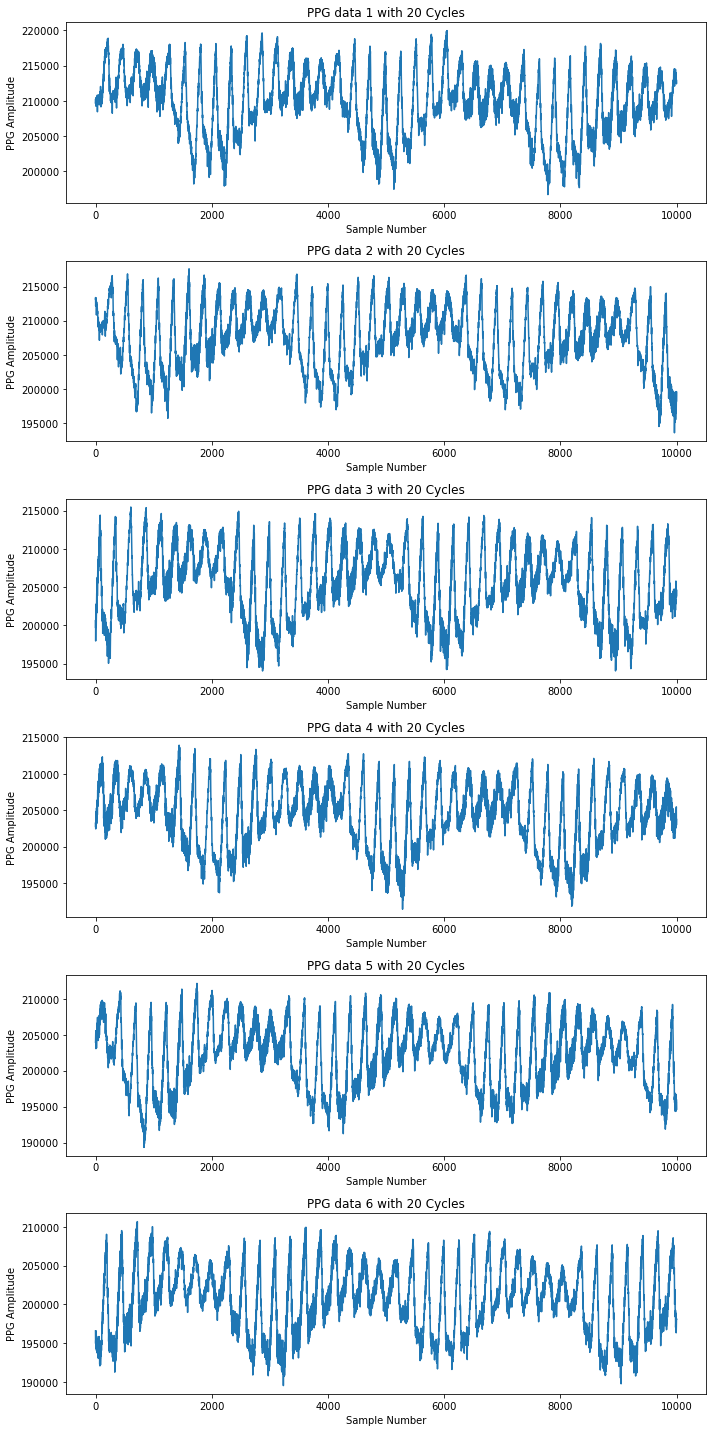

(True, '')

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 使用 with open 命令直接打开和读取文件 提取第一列数据
file_path = '2022.03.12__12_33_inf0_940nm.txt'

try:
    with open(file_path, 'r') as file:
        # 读取文件的每一行并提取第一列数据
        original_ppg = [float(line.split('\t')[0].strip()) for line in file]

    
   
    # 设置采样率等参数
    sampling_rate = 500  # Hz
    cycle_duration = 1  
    points_per_cycle = int(sampling_rate * cycle_duration)

    # 计算分割段
    cycles_per_segment = 20
    segments = [original_ppg[i * points_per_cycle * cycles_per_segment:(i + 1) * points_per_cycle * cycles_per_segment] for i in range(6)]

    # 绘图
    fig, axs = plt.subplots(6, 1, figsize=(10, 20))
    for i, segment in enumerate(segments):
        axs[i].plot(segment)
        axs[i].set_title(f'PPG data {i+1} with 20 Cycles')
        axs[i].set_xlabel('Sample Number')
        axs[i].set_ylabel('PPG Amplitude')

    plt.tight_layout()
    plt.show()

    loaded_successfully = True
except Exception as e:
    loaded_successfully = False
    error_message = str(e)

# 输出是否成功加载和错误消息
loaded_successfully, error_message if not loaded_successfully else ""



以上六个子图是对解包后的original_ppg数据绘图 观察各个波段PPG质量好坏 后续分析中需选择质量好的PPG数据进行分析

接下来选择截取质量好的PPG波段数据 将这一段数据进行后续分析 此时数据存储在 ppg_data中

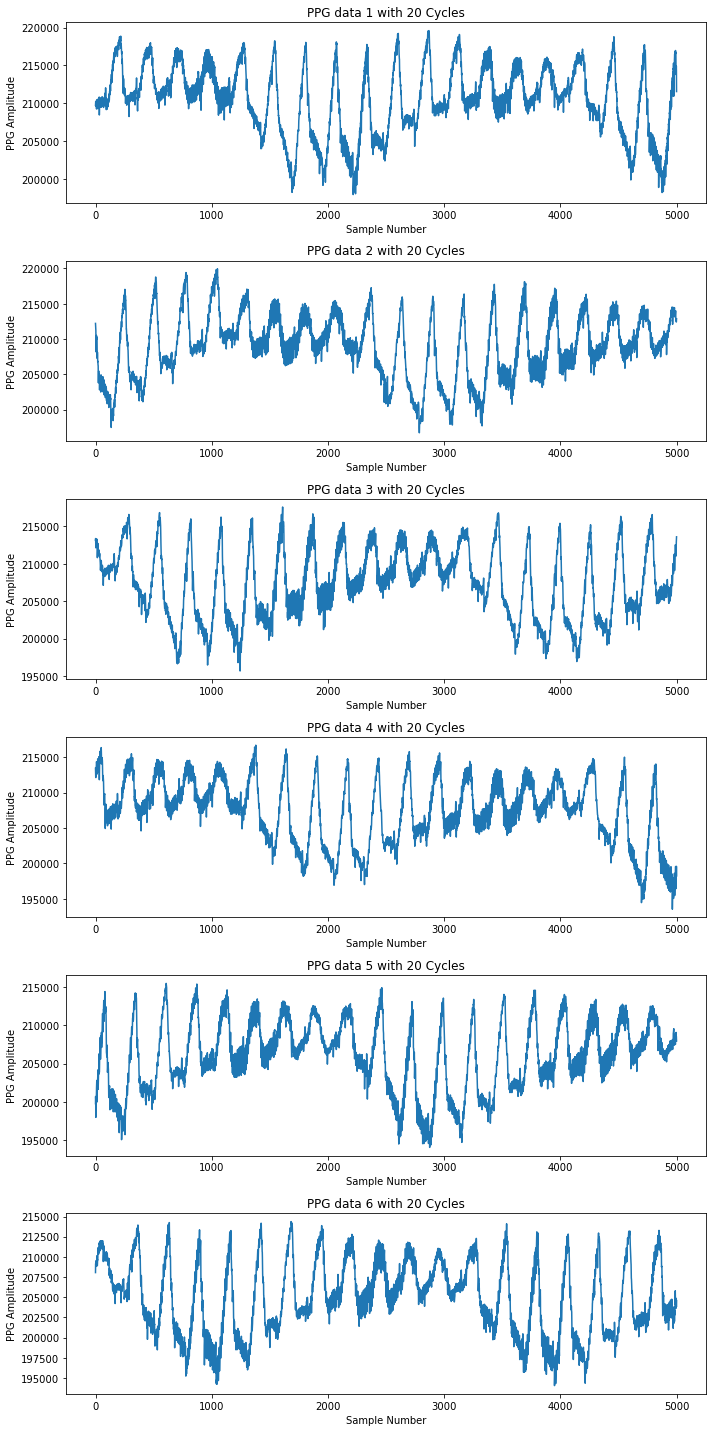

In [8]:
    ppg_data = original_ppg
    # 计算分割段[a:b] a为数据开始的索引 b为数据结束的索引
    cycles_per_segment = 10
    segments = [ppg_data[i * points_per_cycle * cycles_per_segment:(i + 1) * points_per_cycle * cycles_per_segment] for i in range(6)]

    # 绘图
    fig, axs = plt.subplots(6, 1, figsize=(10, 20))
    for i, segment in enumerate(segments):
        axs[i].plot(segment)
        axs[i].set_title(f'PPG data {i+1} with 20 Cycles')
        axs[i].set_xlabel('Sample Number')
        axs[i].set_ylabel('PPG Amplitude')

    plt.tight_layout()
    plt.show()


以上六个子图是选择数据质量较好的PPG波段进行绘制得到的子图  ppg_data

对PPG信号设置巴特沃斯3阶带通滤波器 通带1HZ到15HZ 绘制滤波后的PPG波形图与滤波器频率响应图 此时波形存储在filtered_ppg

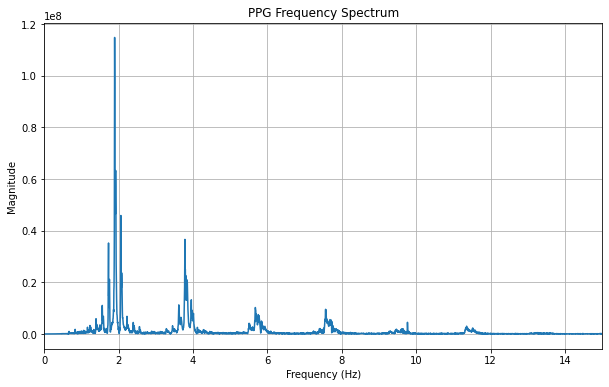

20335
122013


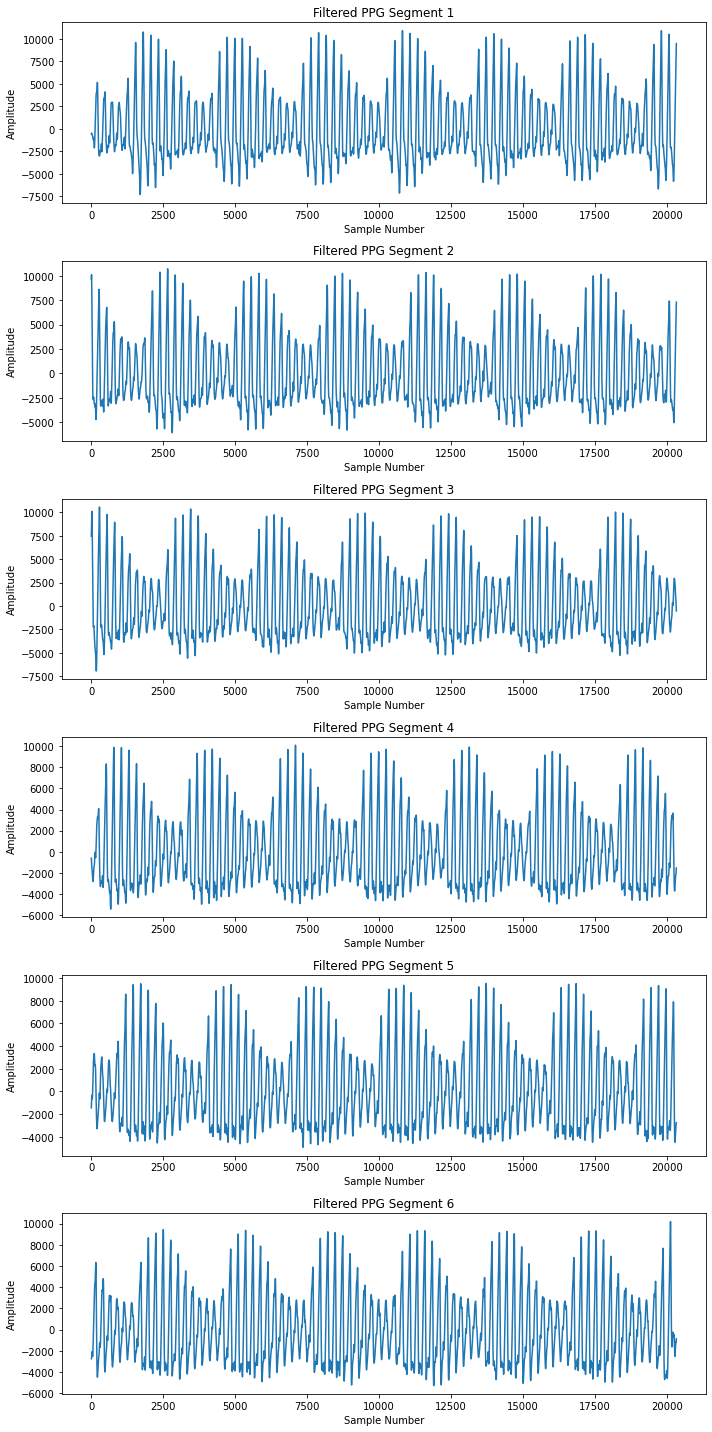

Ripple Suppression (dB): -inf


<ipython-input-9-85a427aca5e4>:104: RuntimeWarning: divide by zero encountered in log10
  ripple_suppression = 20 * np.log10(np.min(np.abs(h)))


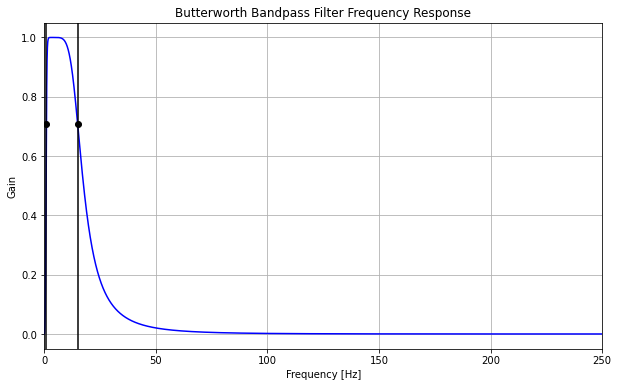

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# 高通和低通滤波器的参数设置
lowcut = 1  # 低通滤波器截止频率 HZ
highcut = 15  # 高通滤波器截止频率 HZ
sampling_rate = 500  # 采样率，单位为Hz
order = 3  # 滤波器的阶数 不能过高 过高把大部分频率信息都丢失

# Butterworth滤波器函数 函数内参 lowcut低频截止频率 highcut高频截止频率 fs采样率 order结束 函数内参可直接调整传入函数
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# 使用Butterworth滤波器对数据进行滤波的函数 data传入函数需要调整的参数 lowcut highcut高低截止频率 fs采样率 order滤波器阶数
def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 对PPG数据进行滤波 滤波后数据存储入filtered_ppg 
filtered_ppg = butter_bandpass_filter(ppg_data, lowcut, highcut, sampling_rate, order)

ppg_spectrum = np.fft.rfft(filtered_ppg)
frequencies = np.fft.rfftfreq(len(filtered_ppg), 1/sampling_rate)
# 绘制滤波后的PPG图像
ppg_spectrum = np.fft.rfft(filtered_ppg)
frequencies = np.fft.rfftfreq(len(filtered_ppg), 1/sampling_rate)
# 计算频谱的幅度
magnitude = np.abs(ppg_spectrum)

# 绘制频谱图
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitude)
plt.title('PPG Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 15)  # 展示 0-5Hz 的频谱范围 正常PPG波的基本频率应在1Hz（60次/分钟）到1.67Hz（100次/分钟）之间 低频包含的成分一般为呼吸成分
plt.grid(True)
plt.show()
# 分6个子图绘制滤波后的PPG图像
fig, axs = plt.subplots(6, 1, figsize=(10, 20))
points_per_segment = len(ppg_data) // 6
print(points_per_segment)
print(len(ppg_data))

for i in range(6):
    start_index = i * points_per_segment
    end_index = start_index + points_per_segment
    axs[i].plot(filtered_ppg[start_index:end_index])
    axs[i].set_title(f'Filtered PPG Segment {i+1}')
    axs[i].set_xlabel('Sample Number')
    axs[i].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, freqz

# 参数设置
lowcut = 1  # 低通滤波器截止频率 1 Hz
highcut = 15  # 高通滤波器截止频率 15 Hz
sampling_rate = 500  # 采样率，单位为Hz
order = 3  # 滤波器的阶数

# 巴特沃斯带通滤波器设计
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# 定义滤波函数
def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 设计滤波器并计算频率响应
b, a = butter_bandpass(lowcut, highcut, sampling_rate, order)
w, h = freqz(b, a, worN=8000)

# 绘制滤波器的频率响应图
plt.figure(figsize=(10, 6))
plt.plot(0.5 * sampling_rate * w / np.pi, np.abs(h), 'b')
plt.plot(lowcut, 0.5*np.sqrt(2), 'ko')
plt.plot(highcut, 0.5*np.sqrt(2), 'ko')
plt.axvline(lowcut, color='k')
plt.axvline(highcut, color='k')
plt.xlim(0, 0.5 * sampling_rate)
plt.title("Butterworth Bandpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()

# 计算纹波抑制比（在截止频率处）
ripple_suppression = 20 * np.log10(np.min(np.abs(h)))
print(f"Ripple Suppression (dB): {ripple_suppression:.2f}")

plt.show()



上图是PPG波滤波后绘制 filtered_ppg 以及滤波后频谱图 峰值代表心率频率 次峰值一般代表二尖瓣波值频率 其他高阶高频成分 

PPG波中低频的成分表征基线漂移 也表征呼吸成分 使用巴特斯沃滤波器提取 此时实验体使用呼吸机非自主呼吸 提取出数据存储在ppg_breathing中

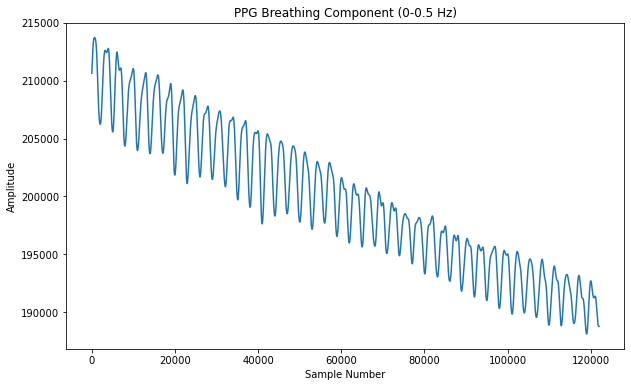

In [10]:
#提取低频基线漂移表征呼吸的成分 进行低通滤波
# 设置低通滤波器的参数
lowcut_breathing = 0.5  # 低通滤波器截止频率，单位为Hz

# Butterworth滤波器设计函数，用于低通滤波
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# 使用Butterworth滤波器对数据进行低通滤波的函数
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 对PPG数据进行低通滤波以提取呼吸成分
ppg_breathing = butter_lowpass_filter(ppg_data, lowcut_breathing, sampling_rate, order)

# 绘制滤波后的PPG呼吸成分图像
plt.figure(figsize=(10, 6))
plt.plot(ppg_breathing)
plt.title('PPG Breathing Component (0-0.5 Hz)')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.show()






上图是PPG中低频呼吸成分 基线漂移 周期一般代表呼吸分量

使用自相关函数方法 提出质量不好的PPG波形 自相关波形的峰值若有明显周期性 则说明波段周期性良好 设置不好的波形在自相关函数的第一个峰值之前 绘制自相关图以及剔除不好波形后的PPG 此时数据存储在ppg_filtered_new

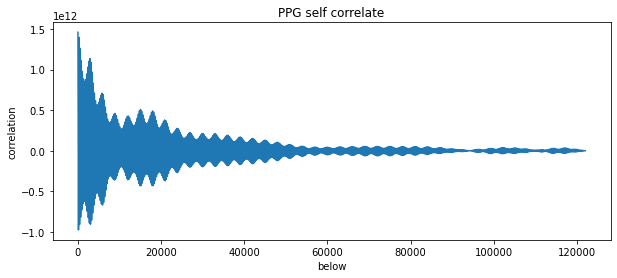

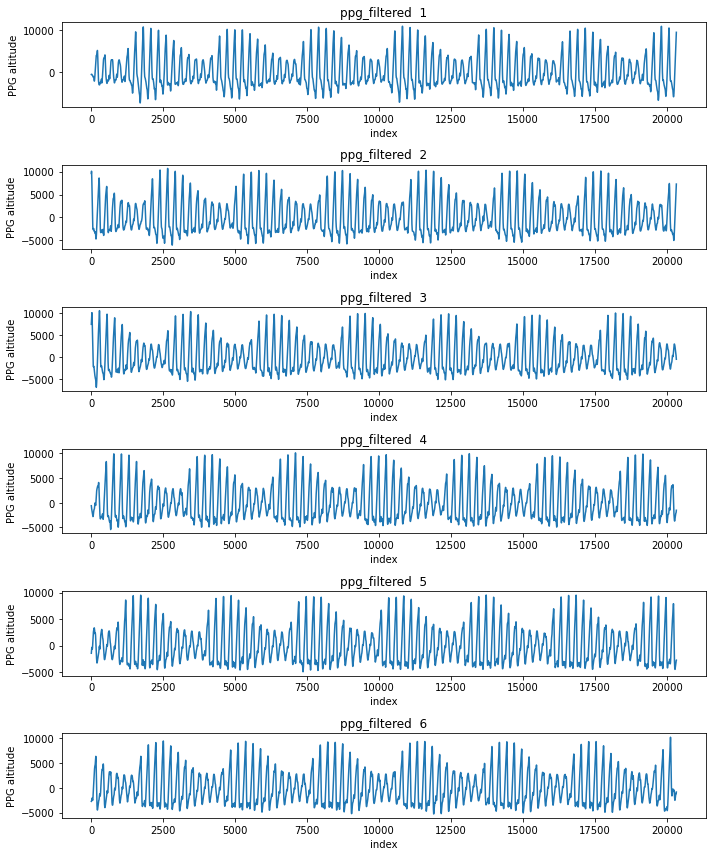

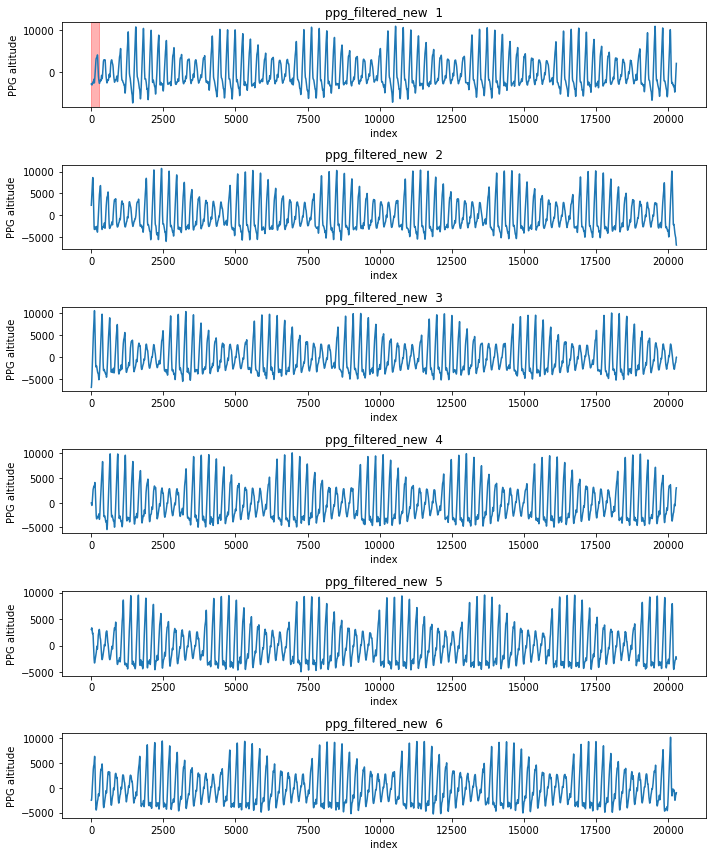

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 假设 ppg_data 是已经过滤和预处理的数据
ppg_filtered = filtered_ppg

# 计算自相关函数
autocorr = np.correlate(ppg_filtered, ppg_filtered, mode='full')
autocorr = autocorr[autocorr.size // 2:]  # 取自相关的一半

# 检测波形质量 使用自相关的峰值
peaks, _ = find_peaks(autocorr, height=max(autocorr)/2)

# 检查peaks数组是否为空
if peaks.size > 0:
    bad_quality_end = peaks[0]  # 设置不好的波形在自相关函数的第一个峰值之前
    # 剔除不好波形前的ppg_filtered
    ppg_filtered_new = ppg_filtered[bad_quality_end:]
else:
    # 如果没有找到峰值，可以选择保留原始数据或者采取其他措施
    print("未找到峰值，保留原始数据。")
    ppg_filtered_new = ppg_filtered
    bad_quality_end = 0  # 假设没有剔除的部分

# 绘制自相关图
plt.figure(figsize=(10, 4))
plt.plot(autocorr)
plt.title('PPG self correlate')
plt.xlabel('below')
plt.ylabel('correlation')
plt.show()

# 将ppg_filtered分为6个子图绘制
subplots = 6
samples_per_subplot = len(ppg_filtered) // subplots

fig, axes = plt.subplots(subplots, 1, figsize=(10, 12))
for i in range(subplots):
    axes[i].plot(ppg_filtered[i * samples_per_subplot: (i + 1) * samples_per_subplot])
    axes[i].set_title(f'ppg_filtered  {i+1}')
    axes[i].set_xlabel('index')
    axes[i].set_ylabel('PPG altitude')
plt.tight_layout()
plt.show()

# 将ppg_filtered_new分为6个子图绘制，并标注剔除的部分
samples_per_subplot_new = len(ppg_filtered_new) // subplots

fig, axes = plt.subplots(subplots, 1, figsize=(10, 12))
for i in range(subplots):
    start_index = i * samples_per_subplot_new
    end_index = (i + 1) * samples_per_subplot_new
    axes[i].plot(ppg_filtered_new[start_index: end_index])
    axes[i].set_title(f'ppg_filtered_new  {i+1}')
    axes[i].set_xlabel('index')
    axes[i].set_ylabel('PPG altitude')
    # 如果当前子图包含了被剔除的部分，则进行标注
    if i == 0:  # 假设剔除的部分在第一个子图中
        axes[i].axvspan(0, bad_quality_end, color='red', alpha=0.3)
plt.tight_layout()
plt.show()


上图是自相关波形以及ppg_filtered_new波形的绘制

在滤波后提取心率与呼吸成分 使用find peaks峰值谷值检测方法 初步确定心跳与呼吸周期 此时对于峰值谷值的标注是有问题 会把局部最小值标注为峰值谷值 

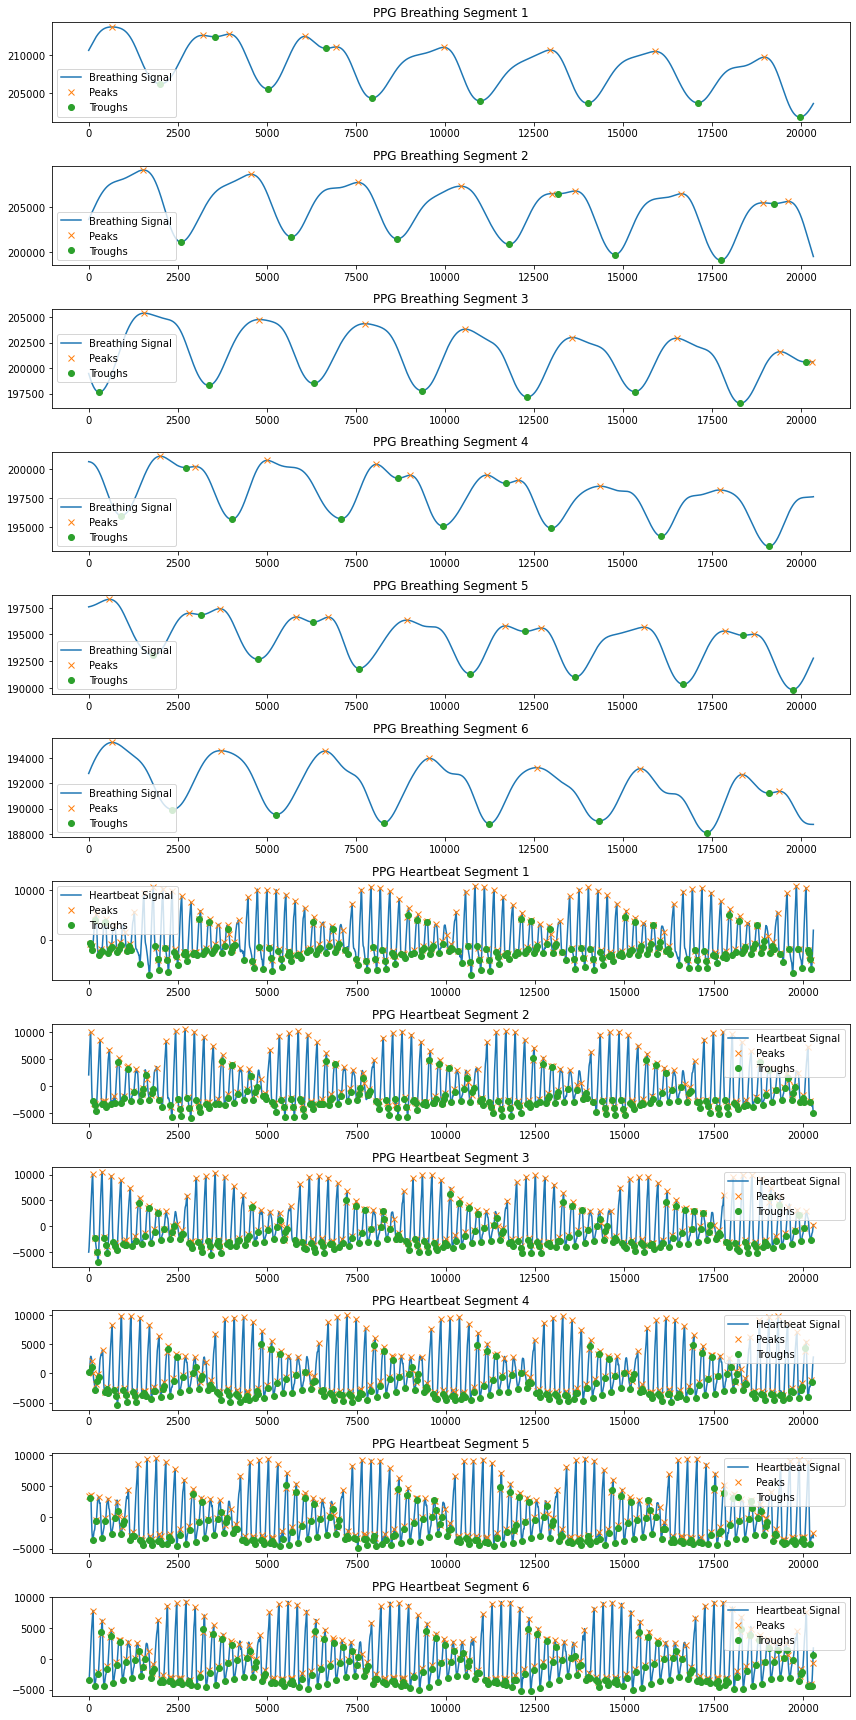

(4.543433962264151, 0.17802340892465252)

In [12]:
from scipy.signal import find_peaks

# ppg_breathing 和 filtered_ppg 滤波之后存储用于表征PPG正常波形反应心率以及低频反映呼吸
# PPG呼吸信号的峰值和谷值 后面发现find peak这个python内置的函数会把所有一阶导数为零点的值识别为峰值谷值 为修改 后面设置峰峰值之间最小间距
peaks_breathing, _ = find_peaks(ppg_breathing)
troughs_breathing, _ = find_peaks(-ppg_breathing)

# 找到PPG心率信号的峰值和谷值
peaks_heartbeat, _ = find_peaks(ppg_filtered_new)
troughs_heartbeat, _ = find_peaks(-ppg_filtered_new)

# 计算呼吸周期的均值 均值作为后面峰峰值间距最小值的依据
breathing_intervals = np.diff(peaks_breathing)
average_breathing_interval = np.mean(breathing_intervals) / sampling_rate

# 计算心率周期的均值
heartbeat_intervals = np.diff(peaks_heartbeat)
average_heartbeat_interval = np.mean(heartbeat_intervals) / sampling_rate

# 分为6个子图绘制每个信号的峰值和谷值
points_per_segment_breathing = len(ppg_breathing) // 6
points_per_segment_heartbeat = len(ppg_filtered_new) // 6

fig, axs = plt.subplots(12, 1, figsize=(12, 24))

for i in range(6):
    # 呼吸信号的子图
    start_index_breathing = i * points_per_segment_breathing
    end_index_breathing = start_index_breathing + points_per_segment_breathing
    segment_breathing = ppg_breathing[start_index_breathing:end_index_breathing]
    peaks_segment_breathing = peaks_breathing[(peaks_breathing >= start_index_breathing) & (peaks_breathing < end_index_breathing)] - start_index_breathing
    troughs_segment_breathing = troughs_breathing[(troughs_breathing >= start_index_breathing) & (troughs_breathing < end_index_breathing)] - start_index_breathing

    axs[i].plot(segment_breathing, label='Breathing Signal')
    axs[i].plot(peaks_segment_breathing, segment_breathing[peaks_segment_breathing], 'x', label='Peaks')
    axs[i].plot(troughs_segment_breathing, segment_breathing[troughs_segment_breathing], 'o', label='Troughs')
    axs[i].set_title(f'PPG Breathing Segment {i+1}')
    axs[i].legend()

    # 心率信号的子图
    start_index_heartbeat = i * points_per_segment_heartbeat
    end_index_heartbeat = start_index_heartbeat + points_per_segment_heartbeat
    segment_heartbeat = filtered_ppg[start_index_heartbeat:end_index_heartbeat]
    peaks_segment_heartbeat = peaks_heartbeat[(peaks_heartbeat >= start_index_heartbeat) & (peaks_heartbeat < end_index_heartbeat)] - start_index_heartbeat
    troughs_segment_heartbeat = troughs_heartbeat[(troughs_heartbeat >= start_index_heartbeat) & (troughs_heartbeat < end_index_heartbeat)] - start_index_heartbeat

    axs[i + 6].plot(segment_heartbeat, label='Heartbeat Signal')
    axs[i + 6].plot(peaks_segment_heartbeat, segment_heartbeat[peaks_segment_heartbeat], 'x', label='Peaks')
    axs[i + 6].plot(troughs_segment_heartbeat, segment_heartbeat[troughs_segment_heartbeat], 'o', label='Troughs')
    axs[i + 6].set_title(f'PPG Heartbeat Segment {i+1}')
    axs[i + 6].legend()

plt.tight_layout()
plt.show()

average_breathing_interval, average_heartbeat_interval
#输出平均周期



以上是对ppg_filtered_new初步标注峰值谷值的图像 输出初步周期 依据初步周期设置峰峰值最小间隔参数 distance参数 避免将局部最小值错误标注为峰值谷值 distance参数依据绘图后结果调整 调整后重新标注峰值谷值并绘图 提取呼吸周期与呼吸周期变异率

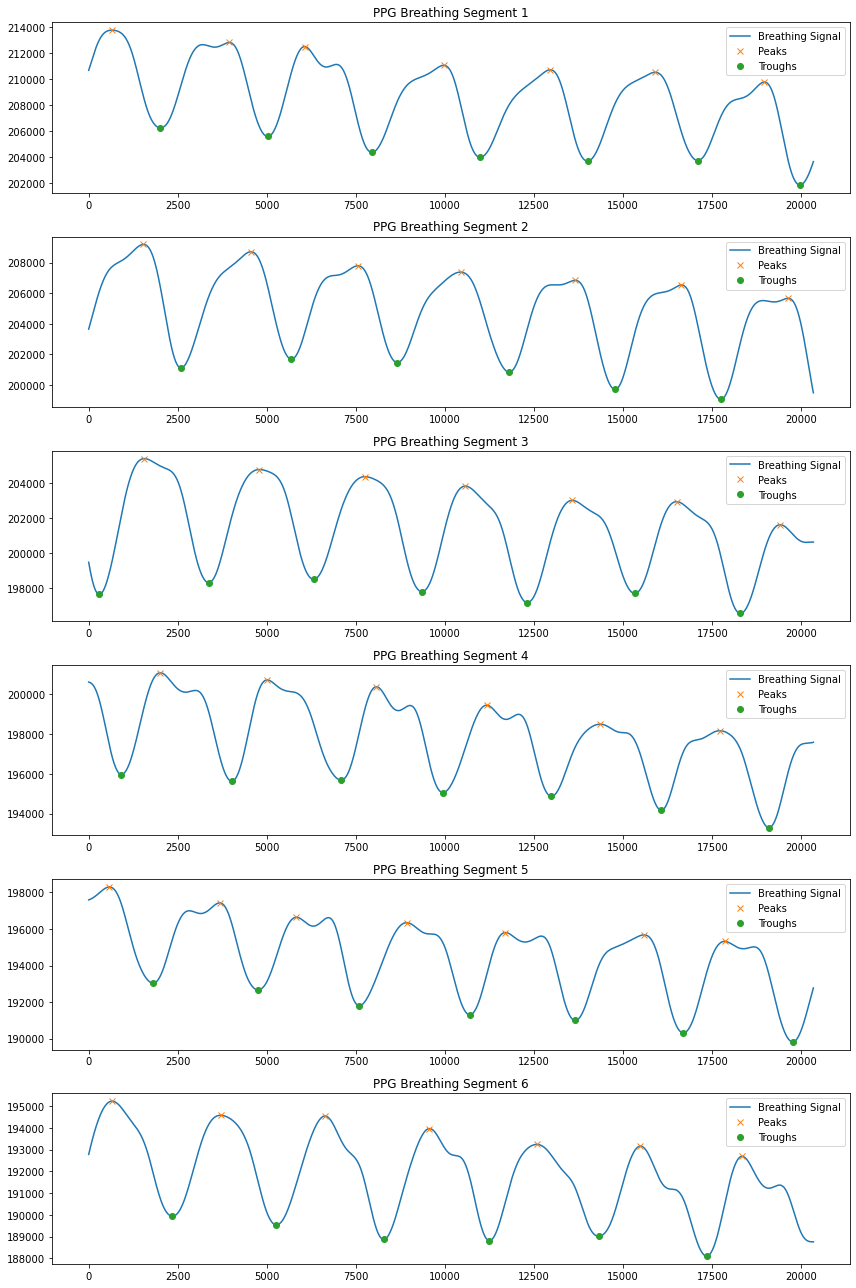

5.96765
0.11593008390471592
[6.572 4.232 7.806 5.98  5.888 6.132 5.824 6.03  6.008 5.754 6.438 5.96
 5.982 4.548 6.45  5.926 5.63  6.008 5.852 5.818 5.882 5.994 6.132 6.186
 6.374 6.712 6.414 6.188 4.31  6.184 5.538 7.782 4.52  6.296 6.096 5.852
 5.866 6.022 5.816 5.704]
[3286 2116 3903 2990 2944 3066 2912 3015 3004 2877 3219 2980 2991 2274
 3225 2963 2815 3004 2926 2909 2941 2997 3066 3093 3187 3356 3207 3094
 2155 3092 2769 3891 2260 3148 3048 2926 2933 3011 2908 2852]


In [13]:
# 为确保每个周期内只有一个峰值和一个谷值，我们将调整峰值和谷值的提取方法
# 假定每个呼吸周期至少持续2秒钟基于正常的呼吸频率

min_distance_between_peaks = int(sampling_rate * 4)  # 最小峰值间距设为4秒

# 使用find_peaks函数，增加distance参数以确保每个周期内只检测到一个峰值和谷值
peaks_breathing, _ = find_peaks(ppg_breathing, distance=min_distance_between_peaks)
troughs_breathing, _ = find_peaks(-ppg_breathing, distance=min_distance_between_peaks)
breathing_intervals = np.diff(peaks_breathing)
average_breathing_intervalnew = np.mean(breathing_intervals) / sampling_rate #呼吸平均周期
breathing_periods = np.diff(peaks_breathing) / sampling_rate  
breathing_period_variability = np.std(breathing_periods) / np.mean(breathing_periods) #呼吸周期变异率
# 分6个子图绘制调整后的峰值和谷值
# 修改峰值和谷值索引的处理方式，以避免索引越界的错误

fig, axs = plt.subplots(6, 1, figsize=(12, 18))

for i in range(6):
    start_index = i * points_per_segment_breathing
    end_index = start_index + points_per_segment_breathing
    segment_breathing = ppg_breathing[start_index:end_index]

    # 确保峰值和谷值索引在当前分段的范围内
    segment_peaks = [peak for peak in peaks_breathing if start_index <= peak < end_index]
    segment_troughs = [trough for trough in troughs_breathing if start_index <= trough < end_index]

    # 将全局索引转换为当前分段的相对索引
    segment_peaks_relative = [peak - start_index for peak in segment_peaks]
    segment_troughs_relative = [trough - start_index for trough in segment_troughs]

    axs[i].plot(segment_breathing, label='Breathing Signal')
    axs[i].plot(segment_peaks_relative, segment_breathing[segment_peaks_relative], 'x', label='Peaks')
    axs[i].plot(segment_troughs_relative, segment_breathing[segment_troughs_relative], 'o', label='Troughs')
    axs[i].set_title(f'PPG Breathing Segment {i+1}')
    axs[i].legend()

plt.tight_layout()
plt.show()
print(average_breathing_intervalnew)
print(breathing_period_variability)
print(breathing_periods)
print(breathing_intervals)
#输出呼吸周期均值 呼吸周期变异率

对 0.5HZ-15HZ PPG波形做相同处理 distance参数可调 重新标注峰值谷值并绘图 提取精确周期与心率变异率

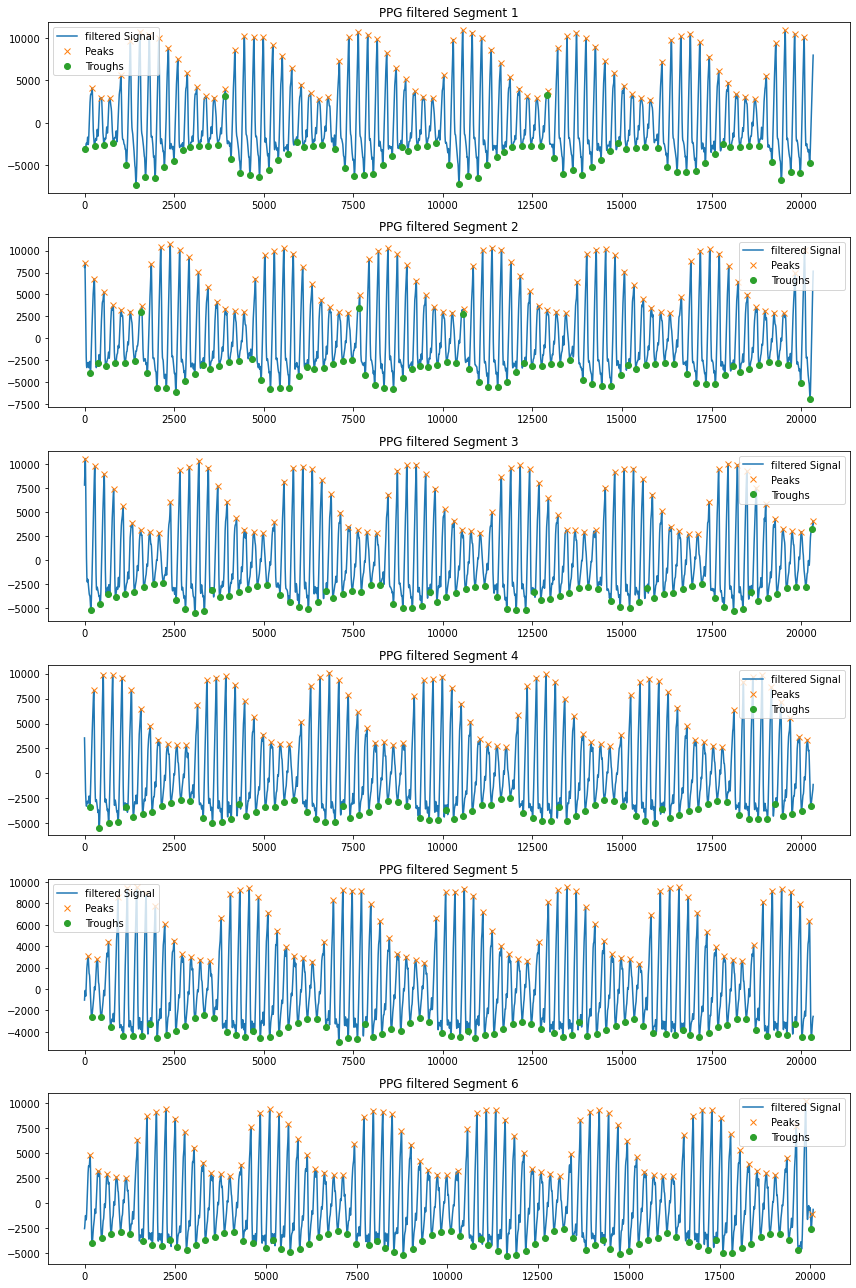

0.5249157667386609
0.08035692784159285
[0.522 0.466 0.618 0.528 0.53  0.528 0.53  0.532 0.528 0.526 0.528 0.522
 0.464 0.616 0.53  0.528 0.532 0.524 0.532 0.528 0.528 0.526 0.526 0.462
 0.522 0.62  0.528 0.53  0.528 0.528 0.53  0.526 0.53  0.524 0.446 0.536
 0.622 0.528 0.53  0.53  0.528 0.528 0.53  0.526 0.524 0.452 0.534 0.614
 0.532 0.526 0.53  0.528 0.528 0.528 0.528 0.526 0.446 0.514 0.52  0.65
 0.528 0.528 0.528 0.528 0.528 0.528 0.528 0.448 0.516 0.512 0.648 0.532
 0.526 0.528 0.526 0.528 0.528 0.528 0.526 0.444 0.512 0.634 0.536 0.528
 0.528 0.528 0.526 0.524 0.528 0.52  0.458 0.516 0.524 0.63  0.53  0.53
 0.528 0.526 0.526 0.524 0.524 0.458 0.518 0.514 0.638 0.526 0.53  0.526
 0.53  0.524 0.524 0.528 0.46  0.51  0.526 0.624 0.53  0.528 0.528 0.526
 0.528 0.528 0.524 0.52  0.452 0.508 0.522 0.648 0.526 0.528 0.528 0.526
 0.526 0.53  0.524 0.45  0.514 0.514 0.644 0.528 0.532 0.526 0.528 0.526
 0.526 0.526 0.46  0.508 0.51  0.546 0.628 0.532 0.526 0.528 0.526 0.526
 0.524 0.528 0

In [14]:
# 为确保每个周期内只有一个峰值和一个谷值，我们将调整峰值和谷值的提取方法
# 假定每个PPG周期至少持续0.5秒钟
ppg_filtered=ppg_filtered_new
points_per_segment_filtered=points_per_segment_breathing
min_distance_between_peaks = int(sampling_rate * 0.35)  # 最小峰值间距设为0.5秒

# 使用find_peaks函数，增加distance参数以确保每个周期内只检测到一个峰值和谷值
peaks_filtered, _ = find_peaks(ppg_filtered, distance=min_distance_between_peaks)
troughs_filtered, _ = find_peaks(-ppg_filtered, distance=min_distance_between_peaks)
filtered_intervals = np.diff(peaks_filtered)
average_filtered_interval = np.mean(filtered_intervals) / sampling_rate #呼吸平均周期
filtered_periods = np.diff(peaks_filtered) / sampling_rate  
filtered_period_variability = np.std(filtered_periods) / np.mean(filtered_periods) #呼吸周期变异率
# 分6个子图绘制调整后的峰值和谷值
# 修改峰值和谷值索引的处理方式，以避免索引越界的错误

fig, axs = plt.subplots(6, 1, figsize=(12, 18))

for i in range(6):
    start_index = i * points_per_segment_filtered
    end_index = start_index + points_per_segment_filtered
    segment_filtered = ppg_filtered[start_index:end_index]

    # 确保峰值和谷值索引在当前分段的范围内
    segment_peaks = [peak for peak in peaks_filtered if start_index <= peak < end_index]
    segment_troughs = [trough for trough in troughs_filtered if start_index <= trough < end_index]

    # 将全局索引转换为当前分段的相对索引
    segment_peaks_relative = [peak - start_index for peak in segment_peaks]
    segment_troughs_relative = [trough - start_index for trough in segment_troughs]

    axs[i].plot(segment_filtered, label='filtered Signal')
    axs[i].plot(segment_peaks_relative, segment_filtered[segment_peaks_relative], 'x', label='Peaks')
    axs[i].plot(segment_troughs_relative, segment_filtered[segment_troughs_relative], 'o', label='Troughs')
    axs[i].set_title(f'PPG filtered Segment {i+1}')
    axs[i].legend()

plt.tight_layout()
plt.show()
print(average_filtered_interval)
print(filtered_period_variability)
print(filtered_periods)
print(filtered_intervals)


提取PPG波的直流分量与交流分量 先提取A1表征交流分量的峰峰值 A2表征二尖瓣降波值（峰值之后第一个曲率为零的点与谷值之间垂直距离）A3表征直流分量 对于A3的提取使用原始数据中DC分量直流均值 对于A1,A2的提取 由于有的PPG波中不存在二尖瓣波值 需选择完好的波形

首先提取DC分量 用orinal_ppg的数据均值作为直流分量

In [15]:
# 提取DC分量 - 使用原始PPG数据的直流均值 原始没有经过滤波的PPG数据中包含原始DC分量信息 滤波去除低频分量会滤除DC信息
DC_value = np.mean(ppg_data)
print(DC_value)


199782.02815273782


提取交流振幅分量 两个波谷界定一个周期 周期中波峰与较低波谷的垂直距离作为振幅分量

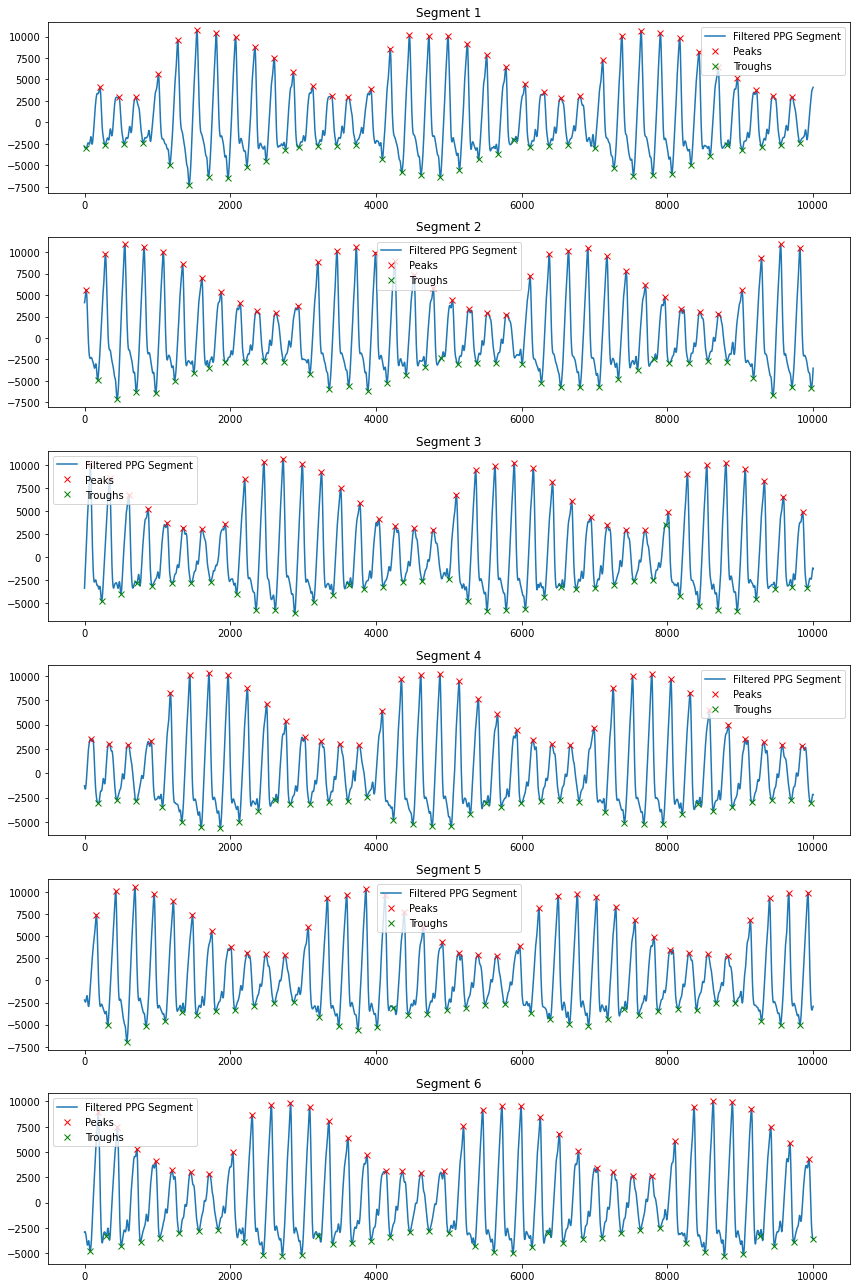

10220.712881507721
[7126.236363267657, 5616.536234338863, 5476.495831870481, 8003.077912551224, 14559.113662467766, 18053.439275461213, 16721.591208898964, 16481.661443443638, 13982.885977988677, 11982.446372757513, 9028.98797095448, 7087.782943562304, 5865.139859581977, 5658.898762549728, 6527.279533707435, 12861.01281584477, 16000.010836929921, 16169.327555850432, 16420.352651149904, 14695.762615377911, 12153.07042147559, 10146.989989617054, 6593.387114652553, 6386.82646535628, 5588.931825521877, 5656.322832228234, 10308.68535300882, 15418.741008406334, 16913.51695201488, 16530.22575682076, 15789.127426208823, 13224.874222932493, 10305.825320928385, 7719.665480505275, 6979.591756191698, 5932.231194619888, 5638.252383995423, 7979.498567607869, 14688.979890121533, 18040.912220199425, 16896.22621598521, 16444.245241924502, 13570.988686790237, 11070.454354330759, 8835.172457355531, 6875.641072734239, 5863.211737604211, 5627.028312469538, 6511.980706675, 12998.446426739927, 16126.11844293

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 设置最小峰值和谷值间隔，一个周期至少持续0.5秒，采样率为500Hz
min_peak_distance = 180  # 0.5秒对应的采样点数

# 使用find_peaks找到满足条件的峰值
peaks, _ = find_peaks(ppg_filtered, distance=min_peak_distance)

# 使用find_peaks找到满足条件的谷值
troughs, _ = find_peaks(-ppg_filtered, distance=min_peak_distance)

# 计算每个峰值和相邻谷值之间的差值（峰峰值）
peak_to_trough_amplitudes = [ppg_filtered[peak] - ppg_filtered[troughs[np.argmax(troughs > peak) - 1]] for peak in peaks if np.argmax(troughs > peak) > 0]

# 计算A1，即峰峰值的平均值
Altitude = np.mean(peak_to_trough_amplitudes) if peak_to_trough_amplitudes else 0

fig, axs = plt.subplots(6, 1, figsize=(12, 18))
segment_length = 10000
for i in range(6):
    start_index = i * segment_length
    end_index = start_index + segment_length
    segment = ppg_filtered[start_index:end_index]

    # 调整峰值和谷值的索引，确保它们位于当前分段内
    segment_peaks = [peak - start_index for peak in peaks if start_index <= peak < end_index]
    segment_troughs = [trough - start_index for trough in troughs if start_index <= trough < end_index]

    axs[i].plot(segment, label='Filtered PPG Segment')
    axs[i].plot(segment_peaks, segment[segment_peaks], 'x', label='Peaks', color='red')
    axs[i].plot(segment_troughs, segment[segment_troughs], 'x', label='Troughs', color='green')
    axs[i].set_title(f'Segment {i+1}')
    axs[i].legend()

plt.tight_layout()
plt.show()

# 输出A1的值
print(Altitude)
print(peak_to_trough_amplitudes)



振幅随时间呈现规律性变化 反映低频心脏的泵血效率 振幅变化周期提取出来 (其实是呼吸的基频）

6.27


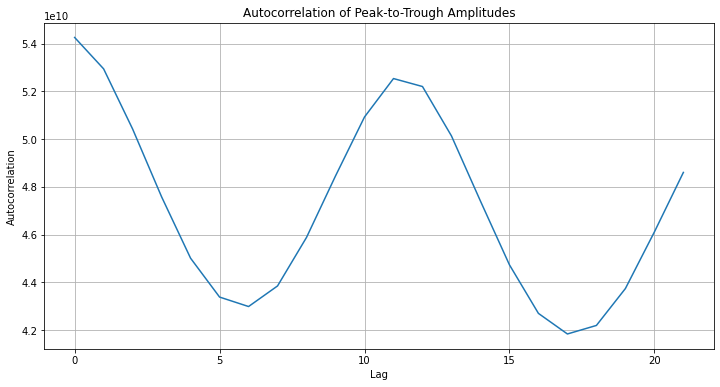

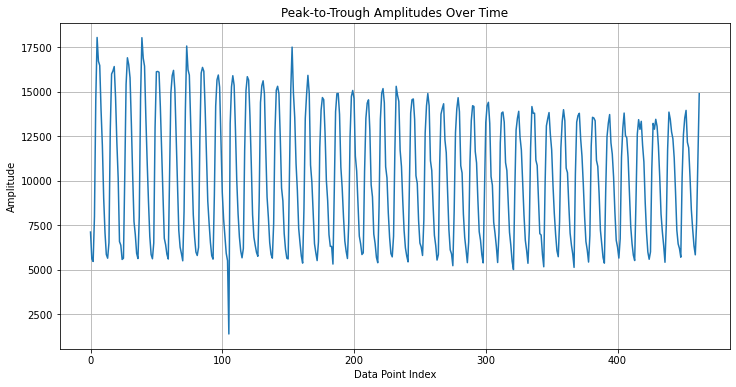

In [17]:
from scipy.signal import correlate, find_peaks
import matplotlib.pyplot as plt

# 计算自相关
auto_corr = correlate(peak_to_trough_amplitudes, peak_to_trough_amplitudes, mode='full')
center = len(auto_corr) // 2

# 从自相关的中心开始寻找第一个峰值，这个峰值代表了周期的长度
auto_corr_peaks, _ = find_peaks(auto_corr[center:])

# 检查是否找到显著的峰值
if len(auto_corr_peaks) > 10:
    # 第一个峰值的位置即为周期
    period = auto_corr_peaks[0]
else:
    # 没有找到显著的峰值，将周期设置为0
    period = 0

# 根据周期计算其他相关参数
period_true = period * 0.57
print(period_true)

# 绘制自相关结果
plt.figure(figsize=(12, 6))
plt.plot(auto_corr[center:center + 2 * period] if period > 0 else auto_corr[center:])
plt.title('Autocorrelation of Peak-to-Trough Amplitudes')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()

# 绘制原始数据
plt.figure(figsize=(12, 6))
plt.plot(peak_to_trough_amplitudes)
plt.title('Peak-to-Trough Amplitudes Over Time')
plt.xlabel('Data Point Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


提取二尖瓣波值 方法：首先先将峰值与谷值在图中标注出来，然后寻找峰值与下一个峰值之间所有局部最小值点（一阶导数为零，并且这个点要排除掉谷值）然后输出并比较他们二阶导数的大小，最后选择二阶导最大的点标注出来 然后增加约束条件 这个点与周期内峰值的垂直距离大于1/3振幅 与周期内谷值距离大于1/3振幅 选择列表中符合条件且一阶导数为0二阶导数最大的点作为二尖瓣波值点

先观察 选择有明显二尖瓣波值的波段存储在ppg_segment中并绘图

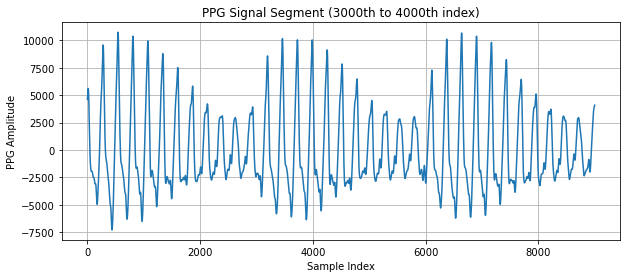

In [87]:
ppg_segment = ppg_filtered_new[1000:10000]

# Plot the segment
plt.figure(figsize=(10, 4))
plt.plot(ppg_segment)
plt.title('PPG Signal Segment (3000th to 4000th index)')
plt.xlabel('Sample Index')
plt.ylabel('PPG Amplitude')
plt.grid(True)
plt.show()

开始标注二尖瓣波值 标注好后绘图 输出二尖瓣波值与周期内谷值距离列表

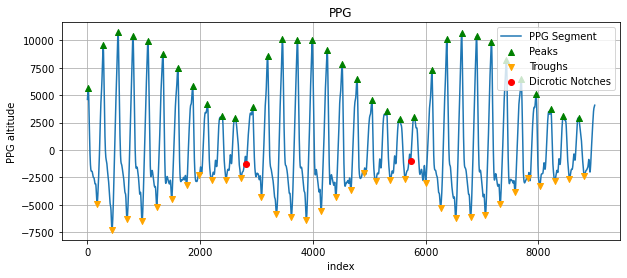

二尖瓣波值垂直距离差值列表: [1314.6458305625363, 1632.763795553007]
二尖瓣波值平均垂直距离差值: 1473.7048130577716
0.05115932086590771
0.007376563481131002


In [88]:
import numpy as np
from scipy.signal import find_peaks, argrelextrema

import numpy as np
from scipy.signal import find_peaks, argrelextrema
#ppg_segment = np.array(ppg_data)
#赋值 列表转化为数组


    
def find_dicrotic_notches_corrected(signal):
    # 找到所有的峰值和谷值，峰值之间的最小间隔设为190个采样点，谷值间隔设为190
    peaks, _ = find_peaks(signal, distance=200)
    troughs, _ = find_peaks(-signal, distance=200)

    # 计算信号的一阶和二阶导数
    first_derivative = np.diff(signal)
    second_derivative = np.diff(first_derivative)
    
    # 初始化二尖瓣波值列表
    dicrotic_notches = []

    # 遍历每个峰值，寻找它和下一个峰值之间的所有局部最小值点
    for i in range(len(peaks) - 1):
        # 检查i+1是否在troughs数组的索引范围内
        if i + 1 < len(troughs):
            # 在当前峰值和下一个峰值之间找到所有的局部最小值点
            local_minima = argrelextrema(signal[peaks[i]:peaks[i+1]], np.less)[0] + peaks[i]
            # 排除谷值
            local_minima = [index for index in local_minima if index not in troughs]

            # 初始化用于比较的二阶导数最大值
            max_second_derivative = -np.inf
            # 初始化用于记录当前最优的二尖瓣波值索引
            best_notch = None

            # 遍历局部最小值点，找出二阶导数最大且符合振幅条件的点
            for local_minimum in local_minima:
                # 确保local_minimum不超出signal的索引范围
                if local_minimum < len(signal) and local_minimum - 1 < len(second_derivative):
                    # 检查与波峰和波谷的振幅条件
                    amplitude_condition_peak = abs(signal[peaks[i]] - signal[local_minimum]) > (abs(signal[peaks[i]] - signal[troughs[i]]) / 3)
                    amplitude_condition_trough = abs(signal[troughs[i+1]] - signal[local_minimum]) > (abs(signal[troughs[i+1]] - signal[peaks[i+1]]) / 3)
                    amplitude_condition = amplitude_condition_peak and amplitude_condition_trough

                    # 检查二阶导数的大小，并更新最优值
                    if second_derivative[local_minimum - 1] > max_second_derivative and amplitude_condition:
                        max_second_derivative = second_derivative[local_minimum - 1]
                        best_notch = local_minimum

            # 如果在当前峰值和下一个峰值之间找到了最优的二尖瓣波值点，将它加入列表
            if best_notch is not None:
                dicrotic_notches.append(best_notch)

    return peaks, troughs, dicrotic_notches


# 调用函数并绘制结果
peaks, troughs, dicrotic_notches = find_dicrotic_notches_corrected(ppg_segment)

# 绘制原始信号，并标注峰值和谷值
plt.figure(figsize=(10, 4))
plt.plot(ppg_segment, label='PPG Segment')
plt.scatter(peaks, ppg_segment[peaks], color='green', marker='^', zorder=5, label='Peaks')
plt.scatter(troughs, ppg_segment[troughs], color='orange', marker='v', zorder=5, label='Troughs')
# 标注二尖瓣波值
plt.scatter(dicrotic_notches, ppg_segment[dicrotic_notches], color='red', zorder=5, label='Dicrotic Notches')
plt.title('PPG')
plt.xlabel('index')
plt.ylabel('PPG altitude')
plt.legend()
plt.grid(True)
plt.show()

# 输出二尖瓣波值的索引和对应的PPG幅度值
dicrotic_notches, ppg_segment[dicrotic_notches]

# 计算二尖瓣波值点与其最邻近的谷值的点的垂直距离差值
def calculate_vertical_distances(signal, notches, troughs):
    vertical_distances = []
    for notch in notches:
        # 找到最邻近的谷值
        nearest_trough = min(troughs, key=lambda x: abs(x - notch))
        # 计算垂直距离差值
        vertical_distance = abs(signal[notch] - signal[nearest_trough])
        vertical_distances.append(vertical_distance)
    return vertical_distances

# 计算距离并存储在列表中
vertical_distances = calculate_vertical_distances(ppg_segment, dicrotic_notches, troughs)

# 打印列表内数据
print("二尖瓣波值垂直距离差值列表:", vertical_distances)

# 计算平均值并打印
average_distance = sum(vertical_distances) / len(vertical_distances)
print("二尖瓣波值平均垂直距离差值:", average_distance)
R1=Altitude/DC_value
R2=average_distance/DC_value
print(R1)
print(R2)

以下代码验证二尖瓣波值是否在PPG波形周期中有确定的位置 并使用0.95置信度t检验

二尖瓣与第一个波谷的水平距离与周期长度的比值： [0.4296875, 0.50390625, 0.80078125, 0.1, 0.85, 0.352059925093633, 0.31203007518796994, 0.5037593984962406, 0.32967032967032966, 0.5128205128205128, 0.49609375, 0.3984375, 0.6138996138996139, 0.4743083003952569, 0.7984189723320159, 0.6742671009771987, 0.8025078369905956, 0.31970260223048325, 0.38461538461538464, 0.5, 0.5128205128205128, 0.3384615384615385, 0.3482587064676617, 0.6965174129353234, 0.5366795366795367, 0.46153846153846156, 0.7307692307692307, 0.6296296296296297, 0.3505535055350554, 0.5387453874538746, 0.4612676056338028, 0.20233463035019456, 0.23076923076923078, 0.45, 0.6285714285714286, 0.6217228464419475, 0.6124031007751938, 0.7945736434108527, 0.13896457765667575, 0.8419618528610354, 0.305019305019305, 0.5019305019305019, 0.20967741935483872, 0.3076923076923077, 0.42857142857142855, 0.6666666666666666, 0.7450980392156863, 0.44664031620553357, 0.8102766798418972, 0.803088803088803, 0.8575418994413407, 0.5724907063197026, 0.24812030075187969, 0.2807

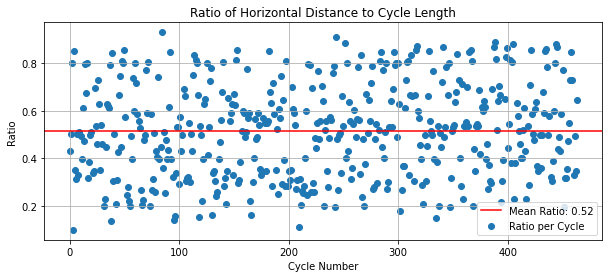

二尖瓣波值与波谷的水平距离比值: [0.4296875, 0.50390625, 0.80078125, 0.1, 0.85, 0.352059925093633, 0.31203007518796994, 0.5037593984962406, 0.32967032967032966, 0.5128205128205128, 0.49609375, 0.3984375, 0.6138996138996139, 0.4743083003952569, 0.7984189723320159, 0.6742671009771987, 0.8025078369905956, 0.31970260223048325, 0.38461538461538464, 0.5, 0.5128205128205128, 0.3384615384615385, 0.3482587064676617, 0.6965174129353234, 0.5366795366795367, 0.46153846153846156, 0.7307692307692307, 0.6296296296296297, 0.3505535055350554, 0.5387453874538746, 0.4612676056338028, 0.20233463035019456, 0.23076923076923078, 0.45, 0.6285714285714286, 0.6217228464419475, 0.6124031007751938, 0.7945736434108527, 0.13896457765667575, 0.8419618528610354, 0.305019305019305, 0.5019305019305019, 0.20967741935483872, 0.3076923076923077, 0.42857142857142855, 0.6666666666666666, 0.7450980392156863, 0.44664031620553357, 0.8102766798418972, 0.803088803088803, 0.8575418994413407, 0.5724907063197026, 0.24812030075187969, 0.28076923076

In [85]:
import matplotlib.pyplot as plt
from scipy import stats
# 计算二尖瓣波值点与周期内第一个波谷的水平距离与整个周期长度的比值
def calculate_ratio(signal, notches, troughs):
    ratios = []

    for notch in notches:
        # 确定在当前二尖瓣波值之前和之后最近的波谷
        previous_troughs = [trough for trough in troughs if trough < notch]
        next_troughs = [trough for trough in troughs if trough > notch]

        if previous_troughs and next_troughs:
            # 找到最近的前一个和后一个波谷
            nearest_previous_trough = max(previous_troughs)
            nearest_next_trough = min(next_troughs)

            # 计算两个波谷之间的水平距离（周期长度）
            cycle_length = nearest_next_trough - nearest_previous_trough

            # 计算二尖瓣波值点与最近前一个波谷之间的水平距离
            horizontal_distance = notch - nearest_previous_trough

            # 计算比值
            if cycle_length != 0:
                ratio = horizontal_distance / cycle_length
                ratios.append(ratio)

    return ratios


# 计算比值
ratios = calculate_ratio(ppg_data, dicrotic_notches, troughs)

# 检验比值是否在一定的置信区间定值
mean_ratio = np.mean(ratios)
std_ratio = np.std(ratios)

# 打印结果
print("二尖瓣与第一个波谷的水平距离与周期长度的比值：", ratios)
print("平均比值：", mean_ratio)
print("标准差：", std_ratio)

# 绘制散点图展示每个周期的比值
plt.figure(figsize=(10, 4))
plt.scatter(range(len(ratios)), ratios, label='Ratio per Cycle')
plt.axhline(y=mean_ratio, color='r', linestyle='-', label=f'Mean Ratio: {mean_ratio:.2f}')
plt.xlabel('Cycle Number')
plt.ylabel('Ratio')
plt.title('Ratio of Horizontal Distance to Cycle Length')
plt.legend()
plt.grid(True)
plt.show()


# 置信度检验
confidence_interval = stats.t.interval(0.95, len(ratios)-1, loc=np.mean(ratios), scale=stats.sem(ratios))

# 打印结果
print("二尖瓣波值与波谷的水平距离比值:", ratios)
print("置信区间:", confidence_interval)



使用有二尖瓣波值的二尖瓣波值在波形中占比的置信区间终点重新标注二尖瓣波值

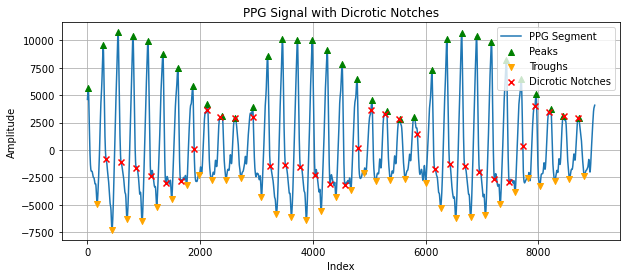

In [114]:
import numpy as np
from scipy.signal import find_peaks, argrelextrema
import matplotlib.pyplot as plt

def find_dicrotic_notches_by_ratio(signal, peaks, troughs, ratio=0.6):    #ratio为二尖瓣波值在周期中的比值
    notches = []

    for i in range(len(troughs)-1):
        start_trough = troughs[i]
        end_trough = troughs[i+1]
        cycle_length = end_trough - start_trough

        # 计算预期的二尖瓣波值位置
        expected_notch_position = start_trough + int(cycle_length * ratio)

        # 确保不会选到峰值
        if expected_notch_position not in peaks:
            notches.append(expected_notch_position)
    
    return notches


# 找到峰值和波谷
peaks, _ = find_peaks(ppg_segment, distance=200)
troughs, _ = find_peaks(-ppg_segment, distance=200)

# 找到二尖瓣波值
dicrotic_notches = find_dicrotic_notches_by_ratio(ppg_segment, peaks, troughs)

# 返回二尖瓣波值索引
dicrotic_notches


# 调用函数并绘制结果
notches = find_dicrotic_notches_with_ratio(ppg_segment)

# 绘制原始信号，并标注峰值和谷值
plt.figure(figsize=(10, 4))
plt.plot(ppg_segment, label='PPG Segment')
plt.scatter(peaks, ppg_segment[peaks], color='green', marker='^', zorder=5, label='Peaks')
plt.scatter(troughs, ppg_segment[troughs], color='orange', marker='v', zorder=5, label='Troughs')
# 标注二尖瓣波值
plt.scatter(dicrotic_notches, ppg_segment[dicrotic_notches], color='red', marker='x', zorder=5, label='Dicrotic Notches')
plt.title('PPG Signal with Dicrotic Notches')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()



求PPG波形线下面积参数S1 S2 S3 首先剔除没有标注出二尖瓣波值的周期 数据存储在ppg_s中并绘图

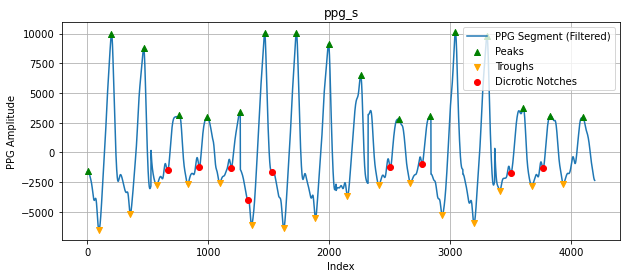

([663, 926, 1190, 1326, 1523, 2506, 2769, 3503, 3768],
 array([-1519.42510696, -1246.9816861 , -1278.33753599, -3972.79088382,
        -1643.0881099 , -1261.42964269,  -983.28780569, -1762.26082026,
        -1326.2922951 ]))

In [20]:
from scipy.signal import find_peaks
import numpy as np


def remove_cycles_without_peaks(signal, troughs, peaks):
    # 保留包含峰值的周期
    retained_cycles = []

    for i in range(len(troughs) - 1):
        # 检查当前周期内是否存在至少一个峰值
        peak_count = sum(p > troughs[i] and p < troughs[i + 1] for p in peaks)
        if peak_count >= 1:
            # 保留此周期
            retained_cycles.extend(signal[troughs[i]:troughs[i + 1]])

    return np.array(retained_cycles)
def remove_cycles_without_notches(signal, troughs, notches):
    # 保留包含二尖瓣波值的周期
    retained_cycles = []
    for i in range(len(troughs) - 1):
        # 检查当前周期内是否存在恰好一个二尖瓣波值
        notch_count = sum(n > troughs[i] and n < troughs[i + 1] for n in notches)
        if notch_count == 1:
            # 保留此周期
            retained_cycles.extend(signal[troughs[i]:troughs[i + 1]])
    return np.array(retained_cycles)

# 应用函数
# 首先确定峰值

peaks, _ = find_peaks(ppg_segment)
# 然后移除没有峰值的周期
signal_with_peaks = remove_cycles_without_peaks(ppg_segment, troughs, peaks)

# 剔除没有标注二尖瓣波值的周期
ppg_s = remove_cycles_without_notches(signal_with_peaks, troughs, dicrotic_notches)

# 使用原来的算法重新标注波峰、波谷和二尖瓣波值
new_peaks_s, new_troughs_s, new_dicrotic_notches_s = find_dicrotic_notches_corrected(ppg_s)

# 绘制新的PPG波形并标注
plt.figure(figsize=(10, 4))
plt.plot(ppg_s, label='PPG Segment (Filtered)')
plt.scatter(new_peaks_s, ppg_s[new_peaks_s], color='green', marker='^', zorder=5, label='Peaks')
plt.scatter(new_troughs_s, ppg_s[new_troughs_s], color='orange', marker='v', zorder=5, label='Troughs')
plt.scatter(new_dicrotic_notches_s, ppg_s[new_dicrotic_notches_s], color='red', zorder=5, label='Dicrotic Notches')
plt.title('ppg_s')
plt.xlabel('Index')
plt.ylabel('PPG Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# 输出新的二尖瓣波值的索引和对应的PPG幅度值
new_dicrotic_notches_s, ppg_s[new_dicrotic_notches_s]


计算ppg波的各个线下面积参数 首先PPG波矩形面积（周期内矩形框出的PPG波形面积）与PPG波总线下面积（底边以及PPG波与底边围成的线下面积）绘图并输出面积参数

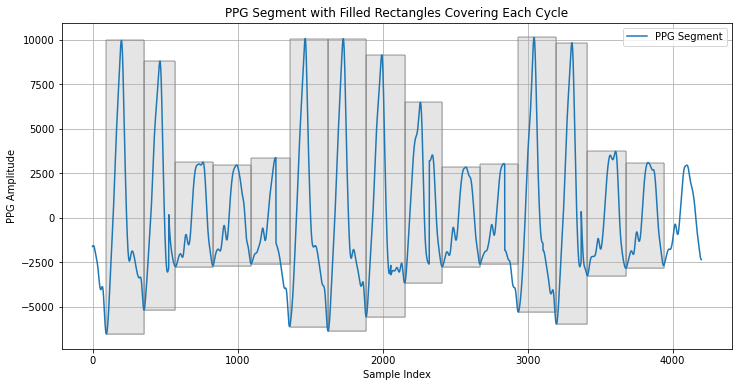

[4268750.313851902, 3034286.257223543, 1513206.08377215, 1493949.2733131284, 1574775.3565250027, 4301041.129856215, 4302132.394601275, 3894377.0930751464, 2638217.397300434, 1453122.274635688, 1493269.2277082538, 4055128.8852108656, 3363084.1417824794, 1849591.8153908, 1542380.110601171]


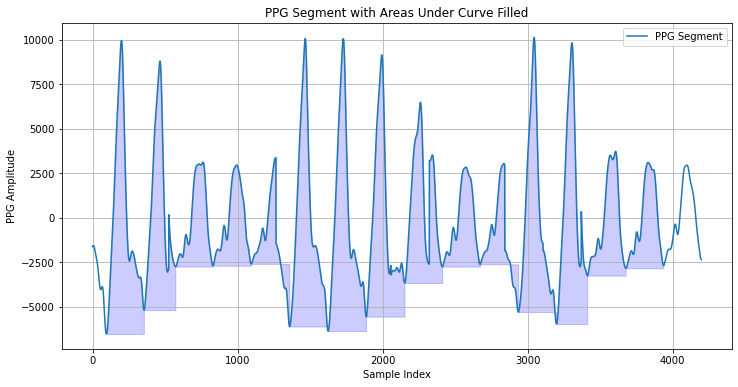

[1702608.0724416482, 1312357.437975174, 702464.8415536357, 695261.5265087043, 317547.365070281, 1619520.5852633682, 1665050.123187386, 1469372.5919659957, 1255821.645867628, 695799.7498990055, 355699.4887559134, 1408612.4990273607, 1477681.8199371668, 843059.1565487345, 733978.9726622785]


In [21]:
def calculate_S1(signal, peaks, troughs):
    S1_areas = []
    cycle_rectangles = []

    # 遍历每对相邻的波谷，计算周期并框出矩形
    for i in range(len(troughs) - 1):
        cycle_start = troughs[i]
        cycle_end = troughs[i + 1]
        cycle_length = cycle_end - cycle_start  # 短边：波谷到波谷的距离

        # 在这个周期内找到最高的波峰值
        peaks_in_cycle = [peak for peak in peaks if cycle_start <= peak < cycle_end]
        if not peaks_in_cycle:  # 如果周期内没有波峰，则跳过
            continue
        max_peak = max(peaks_in_cycle, key=lambda peak: signal[peak])
        amplitude = signal[max_peak] - signal[cycle_start]  # 长边：最大波峰与波谷的垂直距离

        # 计算矩形面积
        area = cycle_length * amplitude
        S1_areas.append(area)

        # 保存矩形的边界以便绘图
        cycle_rectangles.append((cycle_start, cycle_end, signal[cycle_start], signal[max_peak]))

    return S1_areas, cycle_rectangles

# 计算S1面积和周期矩形
S1_areas, cycle_rectangles = calculate_S1(ppg_s, new_peaks_s, new_troughs_s)

# 绘制带有周期矩形的PPG波形，并在矩形内填充颜色

plt.figure(figsize=(12, 6))
plt.plot(ppg_s, label='PPG Segment')
for rect in cycle_rectangles:
    plt.hlines(y=[rect[2], rect[3]], xmin=rect[0], xmax=rect[1], color='grey', alpha=0.5)
    plt.vlines(x=[rect[0], rect[1]], ymin=rect[2], ymax=rect[3], color='grey', alpha=0.5)
    plt.fill_betweenx(y=[rect[2], rect[3]], x1=rect[0], x2=rect[1], color='grey', alpha=0.2)
plt.title('PPG Segment with Filled Rectangles Covering Each Cycle')
plt.xlabel('Sample Index')
plt.ylabel('PPG Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# 输出S1面积
print(S1_areas)
def calculate_ppg_area_under_curve(signal, cycle_rectangles):
    # 计算每个周期内PPG波与底部围成的线下面积
    areas_under_curve = []
    for rect in cycle_rectangles:
        cycle_start = rect[0]
        cycle_end = rect[1]
        baseline = rect[2]  # 波谷值作为基线
        area_under_curve = np.trapz(signal[cycle_start:cycle_end] - baseline, dx=1)
        areas_under_curve.append(area_under_curve)
    return areas_under_curve

# 计算线下面积
areas_under_curve = calculate_ppg_area_under_curve(ppg_s, cycle_rectangles)

# 绘制PPG波形，并填充周期内的线下面积
plt.figure(figsize=(12, 6))
plt.plot(ppg_s, label='PPG Segment')
for rect in cycle_rectangles:
    cycle_start = rect[0]
    cycle_end = rect[1]
    baseline = rect[2]
    plt.fill_between(x=range(cycle_start, cycle_end), y1=ppg_s[cycle_start:cycle_end], y2=baseline, color='blue', alpha=0.2)

plt.title('PPG Segment with Areas Under Curve Filled')
plt.xlabel('Sample Index')
plt.ylabel('PPG Amplitude')
plt.legend()
plt.grid(True)
plt.show()

print(areas_under_curve)


PPG波二尖瓣波值与距离较远波谷与底边围城线下面积 绘图并输出相应面积 对于框不出面积的周期不求算

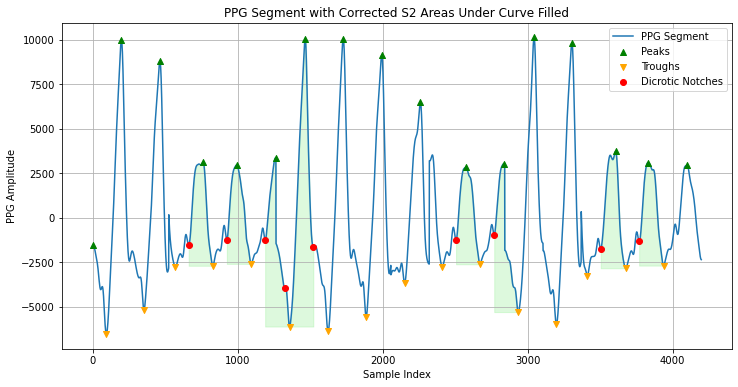

[618203.2196626866,
 569339.1825257922,
 812152.968182087,
 1329526.7620561356,
 575822.9069874838,
 694014.7285926382,
 664340.6081197603,
 616091.6907500178]

In [22]:
def calculate_S2_and_plot_corrected(signal, troughs, notches, cycle_rectangles):
    S2_areas = []
    S2_rectangles = []

    # 计算S2面积并保存矩形边界
    for rect in cycle_rectangles:
        cycle_start, cycle_end, _, _ = rect
        # 在周期内找到二尖瓣波值
        notches_in_cycle = [notch for notch in notches if cycle_start <= notch <= cycle_end]
        if not notches_in_cycle:  # 如果周期内没有二尖瓣波值，则跳过
            continue
        notch = notches_in_cycle[0]  # 取周期内第一个二尖瓣波值

        # 在周期内找到与二尖瓣波值最远的波谷
        troughs_in_cycle = [trough for trough in troughs if cycle_start <= trough <= cycle_end]
        if not troughs_in_cycle:  # 如果周期内没有波谷，则跳过
            continue
        farthest_trough = max(troughs_in_cycle, key=lambda trough: abs(trough - notch))
        
        # 确定底边的起始和结束点
        start = min(notch, farthest_trough)
        end = max(notch, farthest_trough)
        trough_level = signal[farthest_trough]  # 底边的垂直位置

        # 计算S2面积
        area = np.trapz(signal[start:end] - trough_level, dx=1)
        S2_areas.append(area)

        # 保存矩形的边界以便绘图
        S2_rectangles.append((start, end, trough_level, signal[notch]))

    # 绘制PPG波形，并填充S2区域
    plt.figure(figsize=(12, 6))
    plt.plot(signal, label='PPG Segment')
    for rect in S2_rectangles:
        plt.fill_between(x=range(rect[0], rect[1]), y1=signal[rect[0]:rect[1]], y2=rect[2], color='lightgreen', alpha=0.3)

    plt.scatter(new_peaks_s, signal[new_peaks_s], color='green', marker='^', zorder=5, label='Peaks')
    plt.scatter(new_troughs_s, signal[new_troughs_s], color='orange', marker='v', zorder=5, label='Troughs')
    plt.scatter(notches, signal[notches], color='red', zorder=5, label='Dicrotic Notches')

    plt.title('PPG Segment with Corrected S2 Areas Under Curve Filled')
    plt.xlabel('Sample Index')
    plt.ylabel('PPG Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

    return S2_areas

# 重新计算S2面积并绘制
S2_areas_corrected = calculate_S2_and_plot_corrected(ppg_s, new_troughs_s, new_dicrotic_notches_s, cycle_rectangles)

S2_areas_corrected


 PPG上升支面积 绘图并输出面积参数

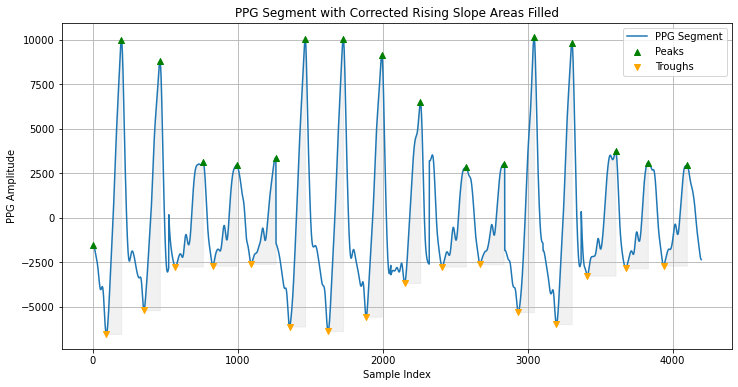

[800007.9694337109,
 742232.9007405281,
 516780.1906687707,
 380607.33011106803,
 371350.21593365725,
 796867.0714592666,
 794339.3053888988,
 771273.0752661707,
 594460.9411567881,
 372507.8740586683,
 370091.99975723086,
 735217.345167739,
 790793.7822684249,
 631403.8640345288,
 331458.0226026058,
 369354.0289597475]

In [23]:
def calculate_rising_slope_area_corrected(signal, troughs, peaks):
    # 计算波谷与下一个波峰之间的线下面积
    corrected_rising_slope_areas = []
    corrected_rising_slope_rectangles = []

    for i in range(len(troughs)):
        trough = troughs[i]
        # 找到下一个波峰
        next_peaks = [peak for peak in peaks if peak > trough]
        if not next_peaks:  # 如果没有下一个波峰，则跳过
            continue
        next_peak = next_peaks[0]
        
        # 计算水平距离（底边）
        horizontal_distance = next_peak - trough
        # 垂直位置取波谷的位置
        trough_level = signal[trough]

        # 计算线下面积
        area = np.trapz(signal[trough:next_peak] - trough_level, dx=1)
        corrected_rising_slope_areas.append(area)

        # 保存矩形的边界以便绘图
        corrected_rising_slope_rectangles.append((trough, next_peak, trough_level, signal[next_peak]))

    return corrected_rising_slope_areas, corrected_rising_slope_rectangles

# 计算修正后的上升支的面积
corrected_rising_slope_areas, corrected_rising_slope_rectangles = calculate_rising_slope_area_corrected(ppg_s, new_troughs_s, new_peaks_s)

# 绘制PPG波形，并填充修正后的上升支区域
plt.figure(figsize=(12, 6))
plt.plot(ppg_s, label='PPG Segment')
for rect in corrected_rising_slope_rectangles:
    plt.fill_between(x=range(rect[0], rect[1]), y1=ppg_s[rect[0]:rect[1]], y2=rect[2], color='lightgray', alpha=0.3)
plt.scatter(new_peaks_s, ppg_s[new_peaks_s], color='green', marker='^', zorder=5, label='Peaks')
plt.scatter(new_troughs_s, ppg_s[new_troughs_s], color='orange', marker='v', zorder=5, label='Troughs')
plt.title('PPG Segment with Corrected Rising Slope Areas Filled')
plt.xlabel('Sample Index')
plt.ylabel('PPG Amplitude')
plt.legend()
plt.grid(True)
plt.show()

corrected_rising_slope_areas


分别取PPG波各个面积参数的平均值 矩形面积 线下面积 到二尖瓣波值的线下面积 上升支面积

In [24]:
# 计算S1_areas, areas_under_curve, S2_areas_corrected, corrected_rising_slope_areas的平均值
average_S1 = sum(S1_areas) / len(S1_areas)
average_areas_under_curve = sum(areas_under_curve) / len(areas_under_curve)
average_S2_corrected = sum(S2_areas_corrected) / len(S2_areas_corrected)
average_corrected_rising_slope = sum(corrected_rising_slope_areas) / len(corrected_rising_slope_areas)

average_S1, average_areas_under_curve, average_S2_corrected, average_corrected_rising_slope


(2718487.4503232036, 1083655.7251109518, 734936.5083595752, 585546.6198129877)

求算脉搏波动力学参数 上升支垂直距离除以上升支时间 二尖瓣波值垂直距离除以二尖瓣波值对应心脏舒张期时间 二者比值相加 将参数在图中标注

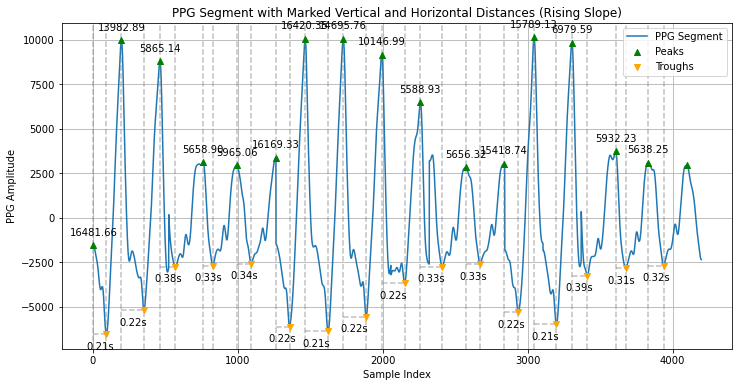

([16481.661443443638,
  13982.885977988677,
  5865.139859581977,
  5658.898762549728,
  5965.058168655313,
  16169.327555850432,
  16420.352651149904,
  14695.762615377911,
  10146.989989617054,
  5588.931825521877,
  5656.322832228234,
  15418.741008406334,
  15789.127426208823,
  6979.591756191698,
  5932.231194619888,
  5638.252383995423],
 [0.206,
  0.22,
  0.378,
  0.326,
  0.338,
  0.216,
  0.208,
  0.216,
  0.218,
  0.326,
  0.328,
  0.218,
  0.212,
  0.39,
  0.306,
  0.322])

In [25]:
def calculate_vertical_horizontal_distances_corrected(signal, troughs, peaks, sampling_rate):
    # 初始化垂直距离和水平距离的列表
    vertical_distances_corrected = []
    horizontal_times_corrected = []  # 水平距离转换为时间

    # 遍历每个波谷和下一个波峰
    for trough in troughs:
        # 找到下一个波峰
        next_peaks = [peak for peak in peaks if peak > trough]
        if not next_peaks:
            continue
        next_peak = next_peaks[0]

        # 计算垂直距离和水平距离
        vertical_distance = signal[next_peak] - signal[trough]
        horizontal_distance = next_peak - trough
        # 将水平距离转换为时间（秒）
        time_duration = horizontal_distance / sampling_rate

        vertical_distances_corrected.append(vertical_distance)
        horizontal_times_corrected.append(time_duration)

    return vertical_distances_corrected, horizontal_times_corrected

# 重新计算垂直和水平距离
vertical_distances_corrected, horizontal_times_corrected = calculate_vertical_horizontal_distances_corrected(ppg_s, new_troughs_s, new_peaks_s, 500)

# 修改代码，以标注周期内波谷到波峰（上升段）的垂直与水平距离
plt.figure(figsize=(12, 6))
plt.plot(ppg_s, label='PPG Segment')
plt.scatter(new_peaks_s, ppg_s[new_peaks_s], color='green', marker='^', zorder=5, label='Peaks')
plt.scatter(new_troughs_s, ppg_s[new_troughs_s], color='orange', marker='v', zorder=5, label='Troughs')
for i in range(min(len(new_troughs_s), len(vertical_distances_corrected))):
    trough = new_troughs_s[i]

    # 确保不会超出 new_peaks_s 的索引范围
    if i >= len(new_peaks_s):
        break
    peak = new_peaks_s[i]

    plt.annotate(f"{vertical_distances_corrected[i]:.2f}", (peak, ppg_s[peak]), textcoords="offset points", xytext=(0,10), ha='center')

    # 检查 horizontal_times_corrected 索引是否有效
    if i < len(horizontal_times_corrected):
        plt.annotate(f"{horizontal_times_corrected[i]:.2f}s", ((trough+peak)/2, ppg_s[trough]), textcoords="offset points", xytext=(0,-15), ha='center')

    # 绘制垂直虚线
    plt.axvline(x=trough, color='grey', linestyle='--', alpha=0.5)
    plt.axvline(x=peak, color='grey', linestyle='--', alpha=0.5)
    # 绘制水平虚线
    plt.hlines(y=ppg_s[trough], xmin=peak, xmax=trough, color='grey', linestyle='--', alpha=0.5)

plt.title('PPG Segment with Marked Vertical and Horizontal Distances (Rising Slope)')
plt.xlabel('Sample Index')
plt.ylabel('PPG Amplitude')
plt.legend()
plt.grid(True)
plt.show()

vertical_distances_corrected, horizontal_times_corrected


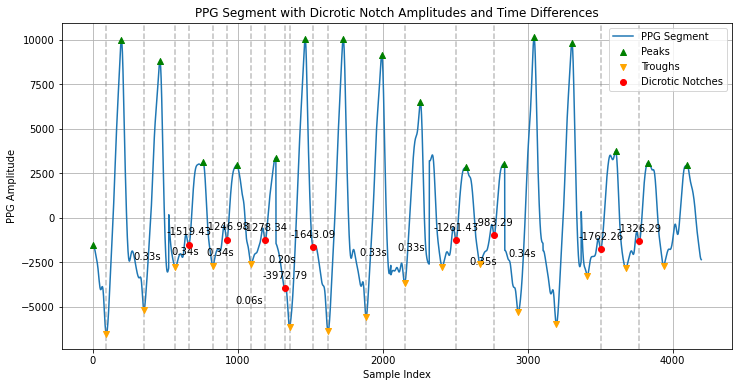

([-1519.4251069582338,
  -1246.9816860998014,
  -1278.3375359854374,
  -3972.7908838170733,
  -1643.0881098975487,
  -1261.4296426948467,
  -983.2878056855527,
  -1762.260820263843,
  -1326.2922950961297],
 [0.334, 0.336, 0.336, 0.064, 0.202, 0.33, 0.332, 0.346, 0.336])

In [26]:
def calculate_dicrotic_notch_distances(signal, troughs, notches, sampling_rate):
    # 初始化二尖瓣波值的纵坐标和与下一个波谷的水平距离差值
    dicrotic_notch_amplitudes = []
    horizontal_time_differences = []

    # 遍历每个二尖瓣波值
    for notch in notches:
        # 找到下一个波谷
        next_troughs = [trough for trough in troughs if trough > notch]
        if not next_troughs:
            continue
        next_trough = next_troughs[0]

        # 计算二尖瓣波值的纵坐标
        dicrotic_notch_amplitude = signal[notch]
        dicrotic_notch_amplitudes.append(dicrotic_notch_amplitude)

        # 计算水平距离差值并转换为时间
        horizontal_distance = next_trough - notch
        time_difference = horizontal_distance / sampling_rate
        horizontal_time_differences.append(time_difference)

    return dicrotic_notch_amplitudes, horizontal_time_differences

# 计算二尖瓣波值的纵坐标和水平时间差
dicrotic_notch_amplitudes, horizontal_time_differences = calculate_dicrotic_notch_distances(ppg_s, new_troughs_s, new_dicrotic_notches_s, 500)

# 绘制ppg_s的波形并标注
plt.figure(figsize=(12, 6))
plt.plot(ppg_s, label='PPG Segment')
plt.scatter(new_peaks_s, ppg_s[new_peaks_s], color='green', marker='^', zorder=5, label='Peaks')
plt.scatter(new_troughs_s, ppg_s[new_troughs_s], color='orange', marker='v', zorder=5, label='Troughs')
plt.scatter(new_dicrotic_notches_s, ppg_s[new_dicrotic_notches_s], color='red', zorder=5, label='Dicrotic Notches')

# 标注水平时间差和二尖瓣波值的纵坐标
for i, notch in enumerate(new_dicrotic_notches_s):
    if i >= len(new_troughs_s) or i >= len(horizontal_time_differences):
        break
    next_trough = new_troughs_s[i]
    plt.annotate(f"{dicrotic_notch_amplitudes[i]:.2f}", (notch, ppg_s[notch]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f"{horizontal_time_differences[i]:.2f}s", ((notch+next_trough)/2, ppg_s[notch]), textcoords="offset points", xytext=(0,-15), ha='center')

    # 画垂直虚线
    plt.axvline(x=notch, color='grey', linestyle='--', alpha=0.5)
    plt.axvline(x=next_trough, color='grey', linestyle='--', alpha=0.5)

plt.title('PPG Segment with Dicrotic Notch Amplitudes and Time Differences')
plt.xlabel('Sample Index')
plt.ylabel('PPG Amplitude')
plt.legend()
plt.grid(True)
plt.show()

dicrotic_notch_amplitudes, horizontal_time_differences


求算比值后相加得到脉搏波动力学参数

In [27]:
# 使用NumPy进行逐元素的除法
import numpy as np
import pandas as pd
dicrotic_notch_amplitudes_abs = np.abs(dicrotic_notch_amplitudes)
# 确保列表转换为NumPy数组
dicrotic_notch_amplitudes_abs_np = np.array(dicrotic_notch_amplitudes_abs)
horizontal_time_differences_np = np.array(horizontal_time_differences)
vertical_distances_corrected_np = np.array(vertical_distances_corrected)
horizontal_times_corrected_np = np.array(horizontal_times_corrected)

# 确保数组长度相同，以最短数组长度为准
min_length = min(len(dicrotic_notch_amplitudes_abs_np), len(horizontal_time_differences_np))
ratio_amplitude_time = dicrotic_notch_amplitudes_abs_np[:min_length] / horizontal_time_differences_np[:min_length]

min_length = min(len(vertical_distances_corrected_np), len(horizontal_times_corrected_np))
ratio_vertical_horizontal = vertical_distances_corrected_np[:min_length] / horizontal_times_corrected_np[:min_length]

print(ratio_amplitude_time)
print(ratio_vertical_horizontal)
# 计算ratio_amplitude_time和ratio_vertical_horizontal的平均值并相加
average_ratio_amplitude_time = np.mean(ratio_amplitude_time) if ratio_amplitude_time.size > 0 else 0
average_ratio_vertical_horizontal = np.mean(ratio_vertical_horizontal) if ratio_vertical_horizontal.size > 0 else 0

sum_of_averages = average_ratio_amplitude_time + average_ratio_vertical_horizontal
print(sum_of_averages)


[ 4549.17696694  3711.25501815  3804.57599996 62074.85755964
  8134.09955395  3822.51406877  2961.71025809  5093.23936492
  3947.29849731]
[80008.06525944 63558.57262722 15516.24301477 17358.5851612
 17648.1010907  74857.99794375 78944.00313053 68035.93803416
 46545.82564045 17143.96265498 17244.88668362 70728.16976333
 74477.01616136 17896.38911844 19386.37645301 17510.10057141]
54453.62316929827


计算lnDC 表征高阶分量

In [28]:
import numpy as np

# 计算DC值的自然对数
log_DC_value = np.log(DC_value)
log_DC_value


12.204982191965422

 将每次运行结果写入txt文件 这是一个保存提取出的参数写入文件程序 每运行一次 字典中的文字备注需修改日期（如3.12 12.33表示3.12号12.33分做的实验数据）

In [29]:


output_file_path_312 = '3.12_new.txt'  # 调整为实际文件路径

data_to_save = {
    "Average Breathing Interval 3.12 (s)": average_breathing_intervalnew,
    "Breathing Period Variability 3.12": breathing_period_variability,
    "Average Heartbeat Interval 3.12 (s)": average_filtered_interval,
    "Heartbeat Period Variability 3.12": filtered_period_variability,
    "R1 AC/DC Component Ratio 3.12": R1,
    "Dicrotic Notch Component to DC Component Ratio 3.12": R2,
    "Average Area of PPG Waveform Bounded by Rectangle 3.12": average_S1,
    "Average Area Under PPG Waveform Curve 3.12": average_areas_under_curve,
    "Average Area Under PPG Waveform Between Dicrotic Notch and First Trough 3.12": average_S2_corrected,
    "Average Area of PPG Waveform Rising Slope 3.12": average_corrected_rising_slope,
    "PPG Pulse Wave Dynamics Parameters 3.12": sum_of_averages,
    "Average DC Component 3.12": DC_value,
    "ln Average DC Component 3.12": log_DC_value,
    "Average Amplitude 3.12": Altitude,
    "Amplitude Variation Period 3.12": period_true,
    "Average Component of Dicrotic Notch 3.12": average_distance
}

# 使用'utf-8'编码以追加模式写入文件
with open(output_file_path_312, 'a', encoding='utf-8') as file:
    for key, value in data_to_save.items():
        file.write(f"{key}: {value}\n")

# 输出文件路径
output_file_path_312





'3.12_new.txt'

全部提取出参数放置于C:\Users\HUAWEI\Desktop\CO.xlsx路径  使用支持向量机SVM回归拟合 绘制拟合散点图于回归系数

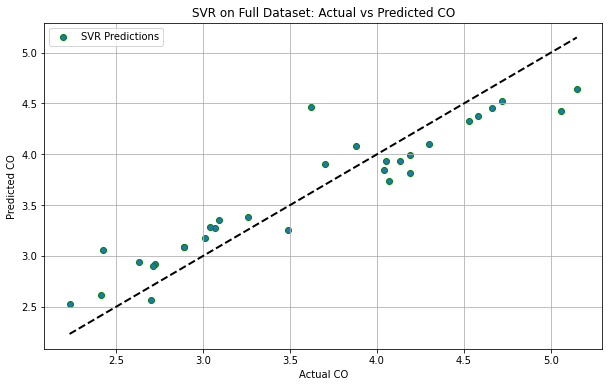

0.8533477797976885
0.10053136355995164


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
import matplotlib.pyplot as plt



# 加载数据
file_path = r"C:\Users\HUAWEI\Desktop\CO.xlsx"
data = pd.read_excel(file_path)

# 提取特定列
columns_for_regression = [
    "Breathing Interval", "Breathing Period Variability",
    "Heartbeat Interval", "Heartbeat Period Variability",
    "AC/DC Component Ratio", "Dicrotic Notch Component to DC Component Ratio",
    "ln Average DC Component", "R1", "R2", "R3"
]
target_column = "CO"

# 仅使用包含所需列的数据
data = data[columns_for_regression + [target_column]].dropna()

# 定义特征和目标变量
X = data[columns_for_regression]
y = data[target_column]

# 对特征进行标准化处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 在完整数据集上使用SVR进行拟合
svr = SVR(C=1.0, epsilon=0.2)
svr.fit(X_scaled, y)

# 使用模型进行预测
y_pred = svr.predict(X_scaled)

# 计算决定系数 (R²) 和均方误差 (MSE)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# 绘制实际值与预测值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, edgecolor='g', label='SVR Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual CO')
plt.ylabel('Predicted CO')
plt.title('SVR on Full Dataset: Actual vs Predicted CO')
plt.legend()
plt.grid(True)
plt.show()

# 输出评估指标
print(r2)
print(mse)



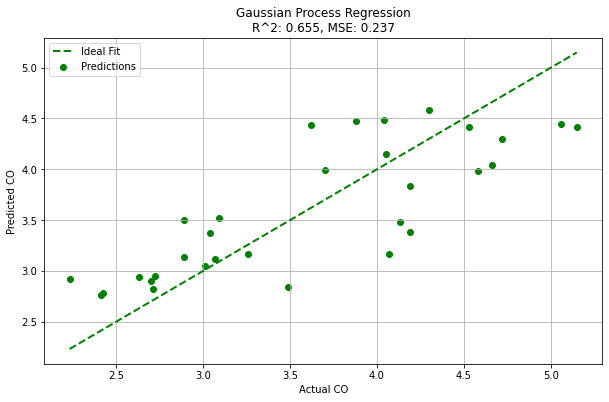

(0.6545874006951977, 0.23678332009563158)

In [63]:
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# 对特征进行标准化处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 优化高斯过程的核函数
kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=np.ones(len(columns_for_regression)), length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))

# 创建高斯过程回归模型
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)

# 拟合模型
gpr.fit(X_scaled, y)

# 进行预测
y_pred, std = gpr.predict(X_scaled, return_std=True)

# 计算评估指标
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# 绘制散点图和拟合直线
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='green', label='Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'g--', lw=2, label='Ideal Fit')
plt.xlabel('Actual CO')
plt.ylabel('Predicted CO')
plt.title(f'Gaussian Process Regression\nR^2: {r2:.3f}, MSE: {mse:.3f}')
plt.legend()
plt.grid(True)
plt.show()

# 输出评估指标
r2, mse



对数据岭回归拟合 绘制散点图 输出回归系数

Coefficient of Determination (R^2) for Ridge Regression on Full Dataset: 0.6353930359276765
Mean Squared Error (MSE) for Ridge Regression on Full Dataset: 0.24994122292236004


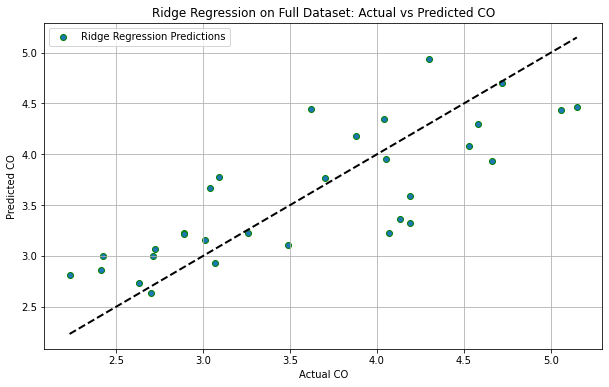

In [31]:
from sklearn.linear_model import Ridge

# 创建岭回归模型
ridge_reg = Ridge(alpha=1.0)

# 在完整数据集上进行拟合
ridge_reg.fit(X_scaled, y)

# 使用模型进行预测
y_pred_ridge = ridge_reg.predict(X_scaled)

# 计算决定系数 (R²) 和均方误差 (MSE)
r2_ridge = r2_score(y, y_pred_ridge)
mse_ridge = mean_squared_error(y, y_pred_ridge)

print("Coefficient of Determination (R^2) for Ridge Regression on Full Dataset:", r2_ridge)
print("Mean Squared Error (MSE) for Ridge Regression on Full Dataset:", mse_ridge)

# 绘制实际值与预测值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_ridge, edgecolor='g', label='Ridge Regression Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual CO')
plt.ylabel('Predicted CO')
plt.title('Ridge Regression on Full Dataset: Actual vs Predicted CO')
plt.legend()
plt.grid(True)
plt.show()



LASSO回归 绘制散点图 输出回归系数

Coefficient of Determination (R^2) for LASSO Regression on Full Dataset: 0.5674048439184123
Mean Squared Error (MSE) for LASSO Regression on Full Dataset: 0.2965477157476178


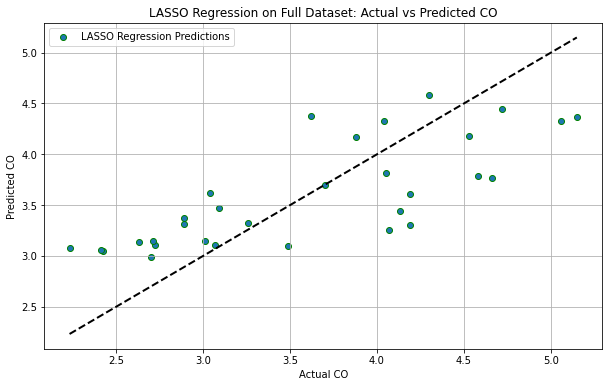

In [32]:
from sklearn.linear_model import Lasso

# 创建LASSO回归模型
lasso_reg = Lasso(alpha=0.1)

# 在完整数据集上进行拟合
lasso_reg.fit(X_scaled, y)

# 使用模型进行预测
y_pred_lasso = lasso_reg.predict(X_scaled)

# 计算决定系数 (R²) 和均方误差 (MSE)
r2_lasso = r2_score(y, y_pred_lasso)
mse_lasso = mean_squared_error(y, y_pred_lasso)

print("Coefficient of Determination (R^2) for LASSO Regression on Full Dataset:", r2_lasso)
print("Mean Squared Error (MSE) for LASSO Regression on Full Dataset:", mse_lasso)

# 绘制实际值与预测值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_lasso, edgecolor='g', label='LASSO Regression Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual CO')
plt.ylabel('Predicted CO')
plt.title('LASSO Regression on Full Dataset: Actual vs Predicted CO')
plt.legend()
plt.grid(True)
plt.show()



随机森林回归 机器学习回归方法 绘制散点图 输出回归系数

Coefficient of Determination (R^2) for Random Forest Regression on Full Dataset: 0.9213840511416818
Mean Squared Error (MSE) for Random Forest Regression on Full Dataset: 0.05389191193548383


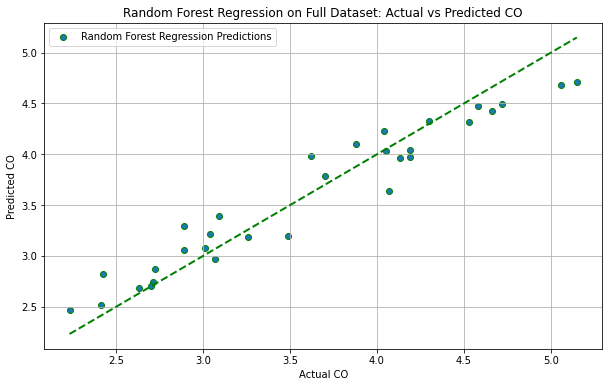

In [33]:
from sklearn.ensemble import RandomForestRegressor

# 创建随机森林回归模型
rf_reg = RandomForestRegressor(n_estimators=100, random_state=0)

# 在完整数据集上进行拟合
rf_reg.fit(X_scaled, y)

# 使用模型进行预测
y_pred_rf = rf_reg.predict(X_scaled)

# 计算决定系数 (R²) 和均方误差 (MSE)
r2_rf = r2_score(y, y_pred_rf)
mse_rf = mean_squared_error(y, y_pred_rf)

print("Coefficient of Determination (R^2) for Random Forest Regression on Full Dataset:", r2_rf)
print("Mean Squared Error (MSE) for Random Forest Regression on Full Dataset:", mse_rf)

# 绘制实际值与预测值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_rf, edgecolor='g', label='Random Forest Regression Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'g--', lw=2)
plt.xlabel('Actual CO')
plt.ylabel('Predicted CO')
plt.title('Random Forest Regression on Full Dataset: Actual vs Predicted CO')
plt.legend()
plt.grid(True)
plt.show()



贝叶斯回归 随机过程回归 输出散点图 输出回归系数

Coefficient of Determination (R^2) for Bayesian Ridge Regression on Full Dataset: 0.5608387771117784
Mean Squared Error (MSE) for Bayesian Ridge Regression on Full Dataset: 0.30104881125361155


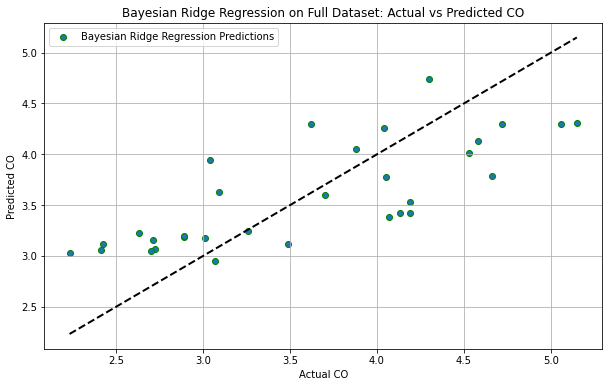

In [34]:
from sklearn.linear_model import BayesianRidge

# 创建贝叶斯回归模型
bayesian_reg = BayesianRidge()

# 在完整数据集上进行拟合
bayesian_reg.fit(X_scaled, y)

# 使用模型进行预测
y_pred_bayesian = bayesian_reg.predict(X_scaled)

# 计算决定系数 (R²) 和均方误差 (MSE)
r2_bayesian = r2_score(y, y_pred_bayesian)
mse_bayesian = mean_squared_error(y, y_pred_bayesian)

print("Coefficient of Determination (R^2) for Bayesian Ridge Regression on Full Dataset:", r2_bayesian)
print("Mean Squared Error (MSE) for Bayesian Ridge Regression on Full Dataset:", mse_bayesian)

# 绘制实际值与预测值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_bayesian, edgecolor='g', label='Bayesian Ridge Regression Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual CO')
plt.ylabel('Predicted CO')
plt.title('Bayesian Ridge Regression on Full Dataset: Actual vs Predicted CO')
plt.legend()
plt.grid(True)
plt.show()



辅助使用PPG包 github上下载 包名：heartpy 自动数据处理 

bpm: 113.519092
ibi: 528.545455
sdnn: 31.978298
sdsd: 39.982613
rmssd: 48.597839
pnn20: 0.312500
pnn50: 0.281250
hr_mad: 2.000000
sd1: 34.350105
sd2: 29.369281
s: 3169.357695
sd1/sd2: 1.169593
breathingrate: 0.286664


D:\Anaconda\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{}

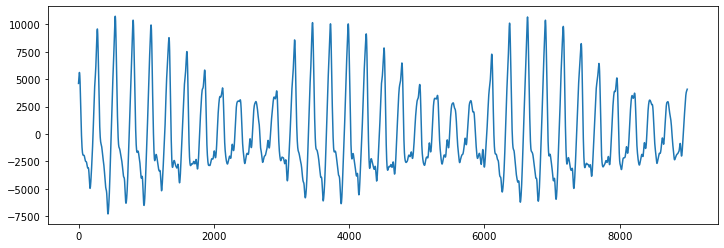

<Figure size 864x288 with 0 Axes>

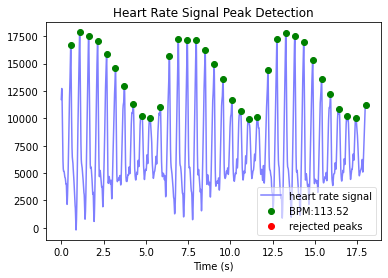

In [131]:
import heartpy as hp
import matplotlib.pyplot as plt
#first let's load the clean PPG signal
data = ppg_segment
#timer = 500

#and visualise
plt.figure(figsize=(12,4))
plt.plot(data)

#run the analysis
wd, m = hp.process(data, sample_rate = 500.0)
#set large figure
plt.figure(figsize=(12,4))

#call plotter
hp.plotter(wd, m)

#display measures computed
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

working_data, measured = hp.process_segmentwise(data, sample_rate=500, segment_width = 20, segment_overlap = 0.04)
measured

这是直接将运算结果写入excel表的程序 使用os交互指令 在桌面上新建excel文件 a追加模式

In [40]:
from openpyxl import load_workbook
import os

# 定义数据字典
data_to_save = {
    "Average Breathing Interval 3.12 (s)": average_breathing_intervalnew,
    "Breathing Period Variability 3.12": breathing_period_variability,
    "Average Heartbeat Interval 3.12 (s)": average_filtered_interval,
    "Heartbeat Period Variability 3.12": filtered_period_variability,
    "R1 AC/DC Component Ratio 3.12": R1,
    "Dicrotic Notch Component to DC Component Ratio 3.12": R2,
    "Average Area of PPG Waveform Bounded by Rectangle 3.12": average_S1,
    "Average Area Under PPG Waveform Curve 3.12": average_areas_under_curve,
    "Average Area Under PPG Waveform Between Dicrotic Notch and First Trough 3.12": average_S2_corrected,
    "Average Area of PPG Waveform Rising Slope 3.12": average_corrected_rising_slope,
    "PPG Pulse Wave Dynamics Parameters 3.12": sum_of_averages,
    "Average DC Component 3.12": DC_value,
    "ln Average DC Component 3.12": log_DC_value,
    "Average Amplitude 3.12": Altitude,
    "Amplitude Variation Period 3.12": period_true,
    "Average Component of Dicrotic Notch 3.12": average_distance
}

# 设置文件路径
desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')
file_name = "PPG_Data.xlsx"
file_path = os.path.join(desktop_path, file_name)

# 检查文件是否存在，如果不存在，则创建
if not os.path.exists(file_path):
    wb = Workbook()
    ws = wb.active
    ws.append(list(data_to_save.keys()))
    wb.save(file_path)

# 加载现有的工作簿
wb = load_workbook(file_path)
ws = wb.active

# 追加一行数据
ws.append(list(data_to_save.values()))

# 保存工作簿
wb.save(file_path)

file_path  # 返回文件路径



'C:\\Users\\HUAWEI\\Desktop\\PPG_Data.xlsx'